In [1]:
# Zachary Katz
# zachary_katz@mines.edu
# November 2024

"""
Plot Figures for Whillans AGU POSTER 2024
and GRADS 2025


v1.0: 22 November 2024
    Poster figs
v2.0 26 February 2026
    Poster Figs for GRADS

"""

# Imports
import datetime
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker


import pandas as pd
import numpy as np
import scipy


from astropy.timeseries import LombScargle

from pyproj import CRS, Transformer
import shapefile
import shapely
from shapely.plotting import plot_line
from shapely.geometry import LineString

from cmap import Colormap
import xarray as xr
import rasterio


sys.path.insert(
    0,
    "/mnt/c/Users/ZacharyKatz/Desktop/WhillansCatPaper/WhillansCatalogPaper/src/Tides",
)
import Tides

################################################################################
########################## User Defined Variables ##############################

min_stas = 2  # Which catalog to use
tide_dir = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background"
tide_mod = "CATS2008-v2023"

########################## User Defined Variables ##############################
################################################################################

In [2]:
# Load slip times based on second derivative
ev_data = {"event": [], "trace_time": []}
df = pd.read_csv(f"../AllEventStartTimes_{min_stas}stas.txt", sep="\t")
ev_data["ev_time"] = df["EventStartTime"]

# Load no data from txt file
no_data = {"interval": [], "starts": [], "ends": []}
df = pd.read_csv(f"../no_data_{min_stas}stas.txt", sep="\t")
no_data["starts"] = df["start"]
no_data["ends"] = df["end"]
diff = [
    datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
    - datetime.datetime.strptime(y, "%Y-%m-%d %H:%M:%S")
    for x, y in zip(no_data["ends"], no_data["starts"])
]
no_data["interval"] = diff

In [3]:
# Calculate time since last events
time_since_last_ev = [
    datetime.timedelta(seconds=1000000)
]  # Set large for first event because prior event time unknown
for i, event in enumerate(ev_data["ev_time"]):
    if i > 0:
        diff = datetime.datetime.strptime(
            ev_data["ev_time"][i], "%Y-%m-%d %H:%M:%S"
        ) - datetime.datetime.strptime(ev_data["ev_time"][i - 1], "%Y-%m-%d %H:%M:%S")
        time_since_last_ev.append(diff)
ev_data["time_since_last_ev"] = time_since_last_ev
print([(a.days * 24 * 3600 + a.seconds) / 3600 for a in ev_data["time_since_last_ev"]])

[277.77777777777777, 17.354166666666668, 21.766666666666666, 10.758333333333333, 13.254166666666666, 19.1125, 22.970833333333335, 10.4875, 11.895833333333334, 9.975, 14.345833333333333, 9.975, 14.845833333333333, 9.9875, 14.658333333333333, 12.0625, 13.1375, 9.808333333333334, 15.225, 10.9875, 14.591666666666667, 10.625, 15.1, 23.866666666666667, 8.416666666666666, 16.3375, 21.929166666666667, 10.666666666666666, 14.5875, 18.954166666666666, 14.941666666666666, 10.7375, 20.645833333333332, 13.025, 12.041666666666666, 11.0125, 13.125, 9.525, 15.145833333333334, 8.875, 15.625, 8.2875, 16.266666666666666, 8.525, 16.9125, 8.5125, 16.4875, 8.55, 19.804166666666667, 16.733333333333334, 11.6625, 12.2, 12.983333333333333, 13.9, 21.4, 20.2, 12.008333333333333, 11.979166666666666, 11.516666666666667, 12.891666666666667, 11.183333333333334, 13.1125, 11.1, 13.5125, 11.545833333333333, 13.420833333333333, 10.85, 14.083333333333334, 10.420833333333333, 14.325, 11.045833333333333, 16.941666666666666,

[(-174.11568595746584, -84.38504722396503), (-174.07363790894706, -84.38708087490528), (-174.03252834334145, -84.38929637003153), (-173.9941263318061, -84.39193572017322), (-173.95194821792526, -84.39181611372216), (-173.90710899077706, -84.39045168887456), (-173.86118811502547, -84.38949590176401), (-173.8148291962652, -84.38878233553352), (-173.76803047357416, -84.38841239171828), (-173.72112609045024, -84.38834365932638), (-173.6742274584149, -84.38855870689241), (-173.62764576571297, -84.38910967700275), (-173.5814536310214, -84.38993610577346), (-173.53591166420026, -84.3910466307691), (-173.49112552234823, -84.39243260584267), (-173.44773757602218, -84.39419044387766), (-173.40529722592322, -84.39616056496061), (-173.36429498918946, -84.39840763385244), (-173.32440343132876, -84.40084127031444), (-173.28402159579116, -84.40319834133297), (-173.24328319333878, -84.40550028801066), (-173.20251122152564, -84.4077994127134), (-173.16170568018524, -84.41009571193077), (-173.1203332639

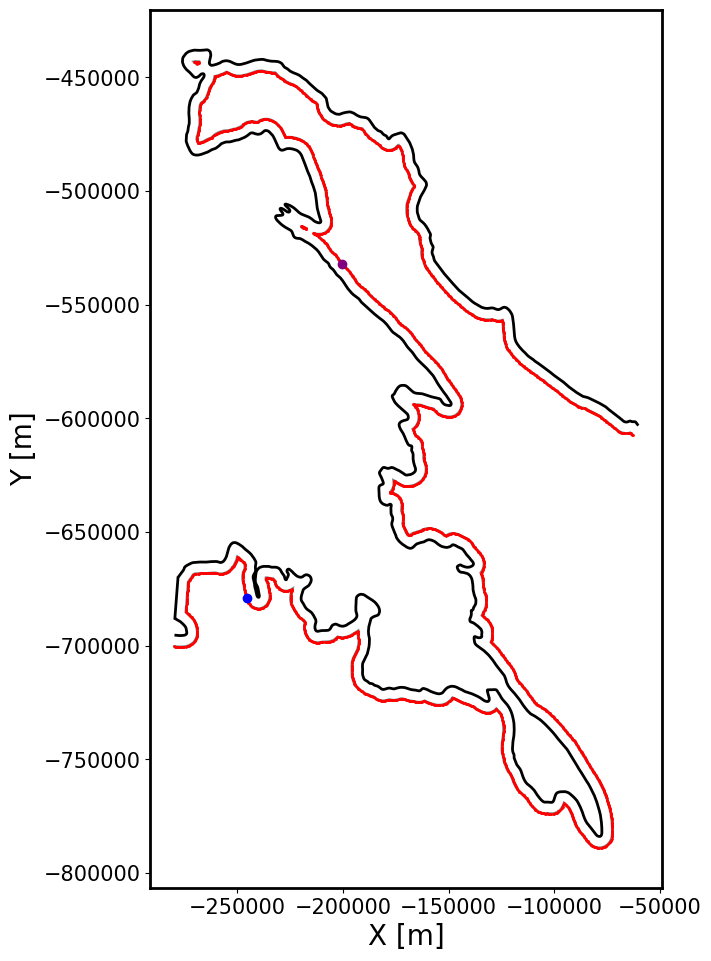

In [5]:
# Calculate difference in tides across basin at event times (from icesat2/gztides.ipynb)
# Helper functions
def inBox(points, bbox):
    # Return points from points that are in bbox
    inbox = []
    for point in points:
        x = point[0]
        y = point[1]
        if x > bbox[0] and x < bbox[2] and y > bbox[1] and y < bbox[3]:
            inbox.append(point)
    return inbox


def interpolateLine(line, dist):
    # Return a new list of points from a linestring that has been interpolated at
    # distance dist. Line must be linestring, dist in m for our case

    # Follows example from:
    # https://stackoverflow.com/questions/34906124/interpolating-every-x-distance-along-multiline-in-shapely
    length = shapely.length(line)
    num_vert = int(np.round(length / dist))
    # print(num_vert)
    return [line.interpolate(n * dist) for n in range(num_vert)]


def xy2ll(x, y):
    """
     Transform coordinates to geodetic coordinates (lon, lat)
     from Antarctic Polar Stereograph coordinates (x, y)

    lon,lat = xy2ll(x,y)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    xy_to_ll = Transformer.from_crs(crs_xy, crs_ll, always_xy=True)
    lon, lat = xy_to_ll.transform(x, y)
    return lon, lat


def ll2xy(lon, lat):
    """
    Transform coordinates from input geodetic coordinates (lon, lat)
    to output Antarctic Polar Stereographic coordinates (x, y)
    Can also take lists of floats!

    Parameters
    lon - Geodetic longitude in EPSG:4326 [float]
    lat - Geodetic latitude in EPSG:4326 [float]

    Returns
    x - Antarctic Polar Stereographic (EPSG:3031) x [float]
    y - Antarctic Polar Stereographic (EPSG:3031) y [float]
    """

    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy=True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y


def dist_sq(x, y):
    # Returns min dist squared between two points
    delta_x = y[0] - x[0]
    delta_y = y[1] - x[1]
    return delta_x * delta_x + delta_y * delta_y


# Extract coordinates of grounding line

# Tuning parameters
offset = 5000  # Distance from grounding line to offset, m
pt_dist = 500  # Distance between tide sampling points, m

# Arrays to pass to tides
x_tide = []
y_tide = []

bbox = [-280000, -800000, -60000, -420000]  # Includes all of Crary
fig, ax = plt.subplots(
    figsize=[(bbox[2] - bbox[0]) / 100000 * 3, (bbox[3] - bbox[1]) / 100000 * 3]
)
# gl_path = '/mnt/d/Background/Antarctica_masks/scripps_antarctica_polygons_v1.shp'
gl_path = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/Antarctica_masks/scripps_antarctica_polygons_v1.shp"
sf = shapefile.Reader(gl_path)
for i, shape in enumerate(sf.shapes(bbox=bbox)):
    if i == 3:
        points = shape.points
        # Only get points within bounding box
        inbox = inBox(points, bbox)
        line = LineString(inbox)
        dilated = line.buffer(3000, single_sided=True)
        offset_line = line.offset_curve(offset)
        plot_line(line, ax=ax, add_points=False, color="black")
        plot_line(offset_line, ax=ax, add_points=False, color="gray")
        # plot_polygon(dilated, ax=ax, add_points=False, color='black')

        interpolated = interpolateLine(offset_line, pt_dist)
        xs = [point.x for point in interpolated]
        ys = [point.y for point in interpolated]
        ax.scatter(xs, ys, s=1, color="red")
        x_tide.append(xs)
        y_tide.append(ys)

ax.xaxis.set_major_locator(ticker.MultipleLocator(50000))
ax.yaxis.set_major_locator(ticker.MultipleLocator(50000))
ax.set_xlabel("X [m]", size=20)
ax.set_ylabel("Y [m]", size=20)
ax.tick_params(labelsize=15)

# Flatten the list. Not sure why this works but here's the source
# https://www.scaler.com/topics/flatten-list-python/
x_tide = sum(x_tide, [])
y_tide = sum(y_tide, [])

lon_lats = [xy2ll(x0, y0) for x0, y0 in zip(x_tide, y_tide)]
lons = [x[0] for x in lon_lats]
lats = [x[1] for x in lon_lats]
print(lon_lats)

x_south = lon_lats[900][0]
y_south = lon_lats[900][1]
x_north = lon_lats[-200][0]
y_north = lon_lats[-200][1]
x_n, y_n = ll2xy(x_north, y_north)
x_s, y_s = ll2xy(x_south, y_south)
ax.scatter(x_n, y_n, color="blue", zorder=2)
ax.scatter(x_s, y_s, color="purple", zorder=2)

[-62593.440298971465, -63016.262162440245, -63426.72885198084, -63803.32861822993, -64251.12006032353, -64741.448041472104, -65238.66050305062, -65737.79263011392, -66237.60086600333, -66734.9613396404, -67228.82329973437, -67715.18756836123, -68193.93486542544, -68662.13336939174, -69118.70502341053, -69555.60020087584, -69979.50116592874, -70384.3764211318, -70774.78343900069, -71170.9365012661, -71571.16062239397, -71971.38474352178, -72371.60886464946, -72778.65610430592, -73185.85611203789, -73593.05611976978, -74000.25612750137, -74407.45613523344, -74814.65614296516, -75221.85615069704, -75629.0561584288, -76036.25616616069, -76443.45617389253, -76843.3949710638, -77235.73406987752, -77621.3035245648, -78006.87297925178, -78404.33373114694, -78844.54962243764, -79284.76551372795, -79724.98140501887, -80165.19729630939, -80605.41318759977, -81054.42103435477, -81508.4711856762, -81962.52133699808, -82416.57148831968, -82870.62163964126, -83324.67179096291, -83778.72194228432, -84

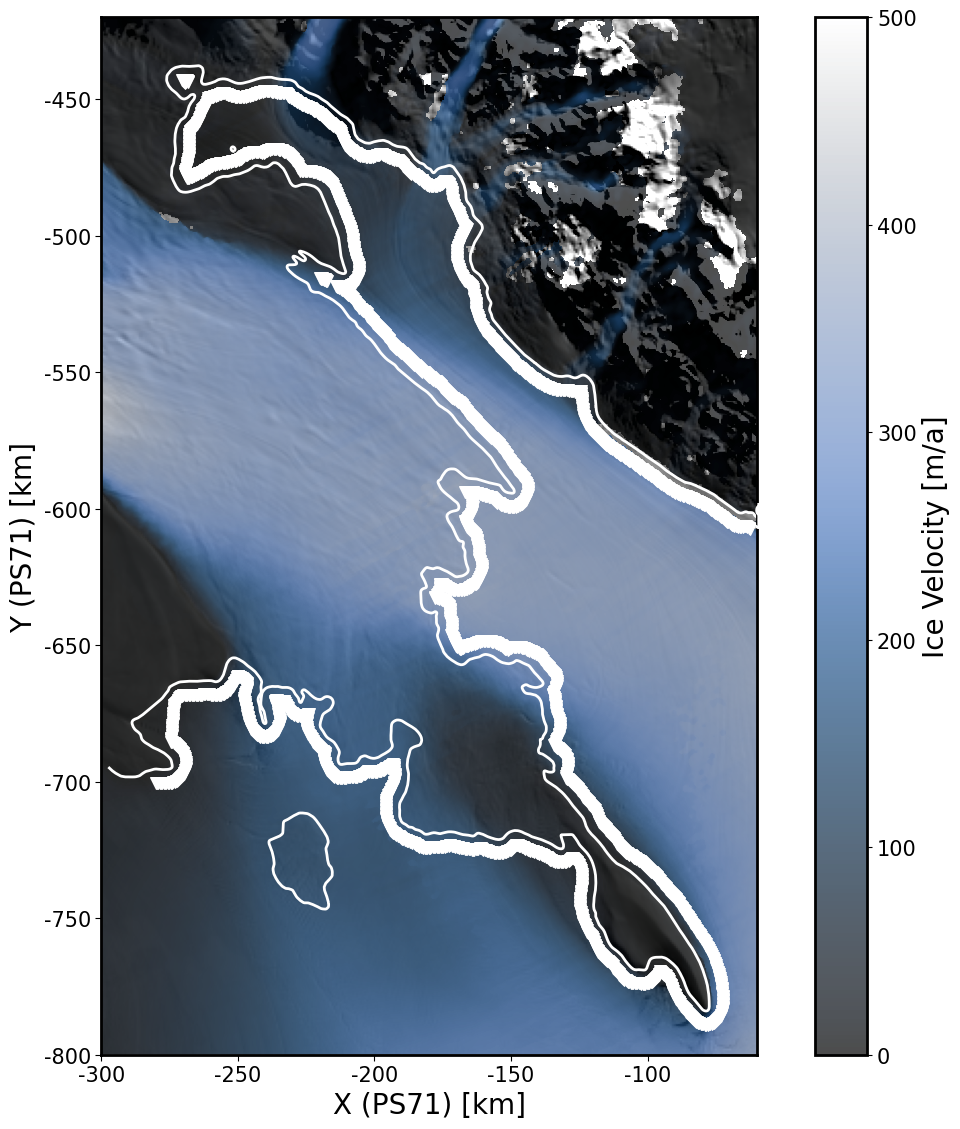

In [9]:
# Plot tide locations

vel_mag_path = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/antarctic_ice_vel_phase_map_v01-vmag.nc"
moa_path = (
    "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/moa750_2009_hp1_v1.1.tif"
)
vel_mag = xr.open_dataarray(vel_mag_path)
bbox = [-300000, -800000, -60000, -420000]  # Includes all of Crary
vel_mag = vel_mag.isel(x=slice(4000, 8000), y=slice(6000, 8000))
x_min_v, x_max_v = vel_mag["x"].min().item(), vel_mag["x"].max().item()
y_min_v, y_max_v = vel_mag["y"].min().item(), vel_mag["y"].max().item()

with rasterio.open(moa_path) as moa:
    bounds = moa.bounds
    left, bottom, right, top = bounds.left, bounds.bottom, bounds.right, bounds.top
    moa_dat = moa.read(1)

ext = (left, right, bottom, top)


oslo = Colormap("crameri:oslo").to_mpl()
# Static frame
bbox = [-300000, -800000, -60000, -420000]  # Includes all of Crary
gl_path = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/Antarctica_masks/scripps_antarctica_polygons_v1.shp"
sf = shapefile.Reader(gl_path)
fig, ax = plt.subplots(
    figsize=[(bbox[2] - bbox[0]) / 100000 * 5, (bbox[3] - bbox[1]) / 100000 * 3]
)
fig.set_tight_layout(True)
ax.imshow(moa_dat, extent=ext, cmap="gray", vmin=15000, vmax=17000)
v = ax.imshow(
    vel_mag,
    extent=(x_min_v, x_max_v, y_min_v, y_max_v),
    cmap=oslo,
    vmax=500,
    vmin=0,
    alpha=0.7,
)
for i, shape in enumerate(sf.shapes(bbox=bbox)):
    if i > 0:
        points = shape.points
        # Only get points within bounding box
        inbox = inBox(points, bbox)
        line = LineString(inbox)
        plot_line(line, ax=ax, add_points=False, color="white")
x_min, x_max = bbox[0], bbox[2]
y_min, y_max = bbox[1], bbox[3]
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
KM_SCALE = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_xlabel("X (PS71) [km]", size=20)
ax.set_ylabel("Y (PS71) [km]", size=20)
ax.tick_params(labelsize=15)
ax.tick_params(size=4)
# ax.set_facecolor("black")
cbarv = fig.colorbar(v)
cbarv.ax.tick_params(labelsize=15)
cbarv.ax.set_ylabel("Ice Velocity [m/a]", size=20)
x, y = ll2xy(lons, lats)
places = ["gz05", "North", "South"]
ax.scatter(x, y, s=70, color="white", marker="v")
print(x)
ax.text(x[0] + 2000, y[0], "gz05", color="white", size=25)
ax.text(x[1] + 2000, y[1], "North", color="white", size=25)
ax.text(x[2] + 2000, y[2], "South", color="white", size=25)

fig.tight_layout()

In [10]:
# Tide time series at gz05
spacing = 4  # Minutes
dates_timeseries = []
initial_time = datetime.datetime.strptime("2007-12-01 00:00:00", "%Y-%m-%d %H:%M:%S")
for i in range(24 * 365 * 12 * 15):
    dates_timeseries.append(initial_time + datetime.timedelta(minutes=spacing * i))

lats = [-84.2986, y_north, y_south]
lons = [-164.5206, x_north, x_south]
places = ["gz05", "North", "South"]

tides = Tides.Tide(tide_mod, tide_dir)
for lat, lon, place in zip(lats, lons, places):
    ev_data[f"tides{place}"] = tides.tidal_elevation(
        [lon], [lat], dates_timeseries
    ).data.T[0]

['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']
['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']
['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']


In [11]:
# Tides at event times
times_to_calculate_tide = ev_data["ev_time"]

dates = [
    datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in times_to_calculate_tide
]

lats = [-84.2986, y_north, y_south]
lons = [-164.5206, x_north, x_south]
places = ["gz05", "North", "South"]

for lat, lon, place in zip(lats, lons, places):
    print(lat, lon, place)
    ev_data[f"tide_event_time_{place}"] = tides.tidal_elevation(
        [lon], [lat], dates
    ).data.T[0]

-84.2986 -164.5206 gz05
['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']
-83.3600956082108 -160.11756237973356 North
['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']
-84.77190054845641 -159.36363595869744 South
['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']


In [12]:
# Save tides at event times
df = pd.DataFrame(
    data={
        "time": ev_data["ev_time"],
        "tide_event_time": ev_data["tide_event_time_gz05"],
    }
)
df.to_csv("tide_event_time_gz05.txt", index=False, sep="\t")

In [13]:
# Calculate distance between event and nearest low and high tides
def dists(ev_data, place):
    # Calculate tidal maxima and minima for comparison

    # https://stackoverflow.com/questions/4624970/finding-local-maxima-minima-with-numpy-in-a-1d-numpy-array

    # Get as indices
    pks = scipy.signal.find_peaks(ev_data[f"tides{place}"], distance=60 / spacing * 3)[
        0
    ]  # Require 5 hrs between peaks
    vlys = scipy.signal.find_peaks(
        -1 * ev_data[f"tides{place}"], distance=60 / spacing * 3
    )[0]  # Require 5 hrs between valleys

    # Also save as times
    pk_times = [dates_timeseries[pk] for pk in pks]
    vly_times = [dates_timeseries[vly] for vly in vlys]

    # Find skipped low tide events (No event within +- 7 hrs of vly)
    skipped_lows = []
    events = [
        datetime.datetime.strptime(event, "%Y-%m-%d %H:%M:%S")
        for event in ev_data["ev_time"]
    ]
    for i, vly in enumerate(vlys):
        valley = dates_timeseries[vly]
        closest_event = min(events, key=lambda d: abs(d - valley))
        skipped = -1
        if abs(closest_event - valley) > datetime.timedelta(hours=6):
            skipped = 1
        skipped_lows.append(skipped)

    skipped_highs = []
    events = [
        datetime.datetime.strptime(event, "%Y-%m-%d %H:%M:%S")
        for event in ev_data["ev_time"]
    ]
    for i, pk in enumerate(pks):
        peak = dates_timeseries[pk]
        closest_event = min(events, key=lambda d: abs(d - peak))
        skipped = -1
        if abs(closest_event - peak) > datetime.timedelta(hours=6):
            skipped = 1
        skipped_highs.append(skipped)

    vly_date = [dates_timeseries[vly] for vly in vlys]
    vly_tide = [ev_data[f"tides{place}"][vly] for vly in vlys]

    pk_date = [dates_timeseries[pk] for pk in pks]
    pk_tide = [ev_data[f"tides{place}"][pk] for pk in pks]

    dist_to_highs = []
    dist_to_lows = []
    closest_highs = []
    closest_lows = []
    high_closers = []
    ht_to_highs = []
    ht_to_lows = []
    high_ht_closers = []
    for i, event in enumerate(ev_data["ev_time"]):
        event = datetime.datetime.strptime(event, "%Y-%m-%d %H:%M:%S")
        closest_high = min(pk_times, key=lambda d: abs(d - event))
        dist_to_high = event - closest_high
        closest_low = min(vly_times, key=lambda d: abs(d - event))

        ht_to_high = (
            ev_data[f"tide_event_time_{place}"][i]
            - ev_data[f"tides{place}"][pks[pk_times.index(closest_high)]]
        )
        ht_to_low = (
            ev_data[f"tide_event_time_{place}"][i]
            - ev_data[f"tides{place}"][vlys[vly_times.index(closest_low)]]
        )
        ht_to_highs.append(ht_to_high)
        ht_to_lows.append(ht_to_low)

        dist_to_low = event - closest_low
        dist_to_highs.append(dist_to_high)
        dist_to_lows.append(dist_to_low)
        closest_highs.append(closest_high)
        closest_lows.append(closest_low)

        if abs(dist_to_high) < abs(dist_to_low):
            high_closer = 1
        else:
            high_closer = 0
        high_closers.append(high_closer)

        if abs(ht_to_high) < abs(ht_to_low):
            high_closer = 1
        else:
            high_closer = 0
        high_ht_closers.append(high_closer)

    dist_dict = {
        "dist_to_highs": dist_to_highs,
        "dist_to_lows": dist_to_lows,
        "closest_highs": closest_highs,
        "closest_lows": closest_lows,
        "high_closers": high_closers,
        "ht_to_highs": ht_to_highs,
        "ht_to_lows": ht_to_lows,
        "high_ht_closers": high_ht_closers,
        "vly_date": vly_date,
        "vly_tide": vly_tide,
        "pk_date": pk_date,
        "pk_tide": pk_tide,
    }
    return dist_dict

In [14]:
dist_gz05 = dists(ev_data, "gz05")
dist_North = dists(ev_data, "North")
dist_South = dists(ev_data, "South")

In [15]:
print(dist_gz05["vly_date"])
print(dist_gz05["pk_date"])
spacing = 1  # Day
dates = []
initial_time = datetime.datetime.strptime("2010-12-12 00:00:00", "%Y-%m-%d %H:%M:%S")
for i in range(365 * 11):
    dates.append(initial_time + datetime.timedelta(days=spacing * i))

[datetime.datetime(2007, 12, 1, 6, 56), datetime.datetime(2007, 12, 1, 21, 32), datetime.datetime(2007, 12, 2, 7, 56), datetime.datetime(2007, 12, 2, 21, 56), datetime.datetime(2007, 12, 3, 8, 52), datetime.datetime(2007, 12, 3, 22, 24), datetime.datetime(2007, 12, 4, 9, 40), datetime.datetime(2007, 12, 4, 22, 48), datetime.datetime(2007, 12, 5, 10, 32), datetime.datetime(2007, 12, 5, 23, 8), datetime.datetime(2007, 12, 6, 11, 32), datetime.datetime(2007, 12, 6, 23, 32), datetime.datetime(2007, 12, 7, 23, 52), datetime.datetime(2007, 12, 9, 0, 24), datetime.datetime(2007, 12, 10, 0, 56), datetime.datetime(2007, 12, 11, 1, 36), datetime.datetime(2007, 12, 12, 2, 16), datetime.datetime(2007, 12, 13, 2, 52), datetime.datetime(2007, 12, 14, 3, 12), datetime.datetime(2007, 12, 15, 2, 40), datetime.datetime(2007, 12, 16, 2, 0), datetime.datetime(2007, 12, 17, 1, 40), datetime.datetime(2007, 12, 18, 0, 56), datetime.datetime(2007, 12, 18, 22, 28), datetime.datetime(2007, 12, 19, 21, 24), date

In [16]:
# Connect axes using https://matplotlib.org/stable/users/explain/text/annotations.html
from matplotlib.transforms import Bbox, TransformedBbox, blended_transform_factory

from mpl_toolkits.axes_grid1.inset_locator import (
    BboxPatch,
    BboxConnector,
    BboxConnectorPatch,
)


def connect_bbox(
    bbox1, bbox2, loc1a, loc2a, loc1b, loc2b, prop_lines, prop_patches=None
):
    if prop_patches is None:
        prop_patches = prop_lines.copy()
        prop_patches["alpha"] = prop_patches.get("alpha", 1) * 0.2

    c1 = BboxConnector(bbox1, bbox2, loc1=loc1a, loc2=loc2a, **prop_lines)
    c1.set_clip_on(False)
    c2 = BboxConnector(bbox1, bbox2, loc1=loc1b, loc2=loc2b, **prop_lines)
    c2.set_clip_on(False)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(
        bbox1,
        bbox2,
        # loc1a=3, loc2a=2, loc1b=4, loc2b=1,
        loc1a=loc1a,
        loc2a=loc2a,
        loc1b=loc1b,
        loc2b=loc2b,
        **prop_patches,
    )
    p.set_clip_on(False)

    return c1, c2, bbox_patch1, bbox_patch2, p


def zoom_effect01(ax1, ax2, xmin, xmax, **kwargs):
    """
    ax1 : the main axes
    ax1 : the zoomed axes
    (xmin,xmax) : the limits of the colored area in both plot axes.

    connect ax1 & ax2. The x-range of (xmin, xmax) in both axes will
    be marked.  The keywords parameters will be used ti create
    patches.

    """

    trans1 = blended_transform_factory(ax1.transData, ax1.transAxes)
    trans2 = blended_transform_factory(ax2.transData, ax2.transAxes)

    bbox = Bbox.from_extents(xmin, 0, xmax, 1)

    mybbox1 = TransformedBbox(bbox, trans1)
    mybbox2 = TransformedBbox(bbox, trans2)

    prop_patches = kwargs.copy()
    prop_patches["ec"] = "none"
    prop_patches["alpha"] = 0.2

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1,
        mybbox2,
        loc1a=3,
        loc2a=2,
        loc1b=4,
        loc2b=1,
        prop_lines=kwargs,
        prop_patches=prop_patches,
    )

    # ax1.add_patch(bbox_patch1)
    # ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p

In [17]:
# Get oslo colormap
oslo = Colormap("crameri:oslo").to_mpl()

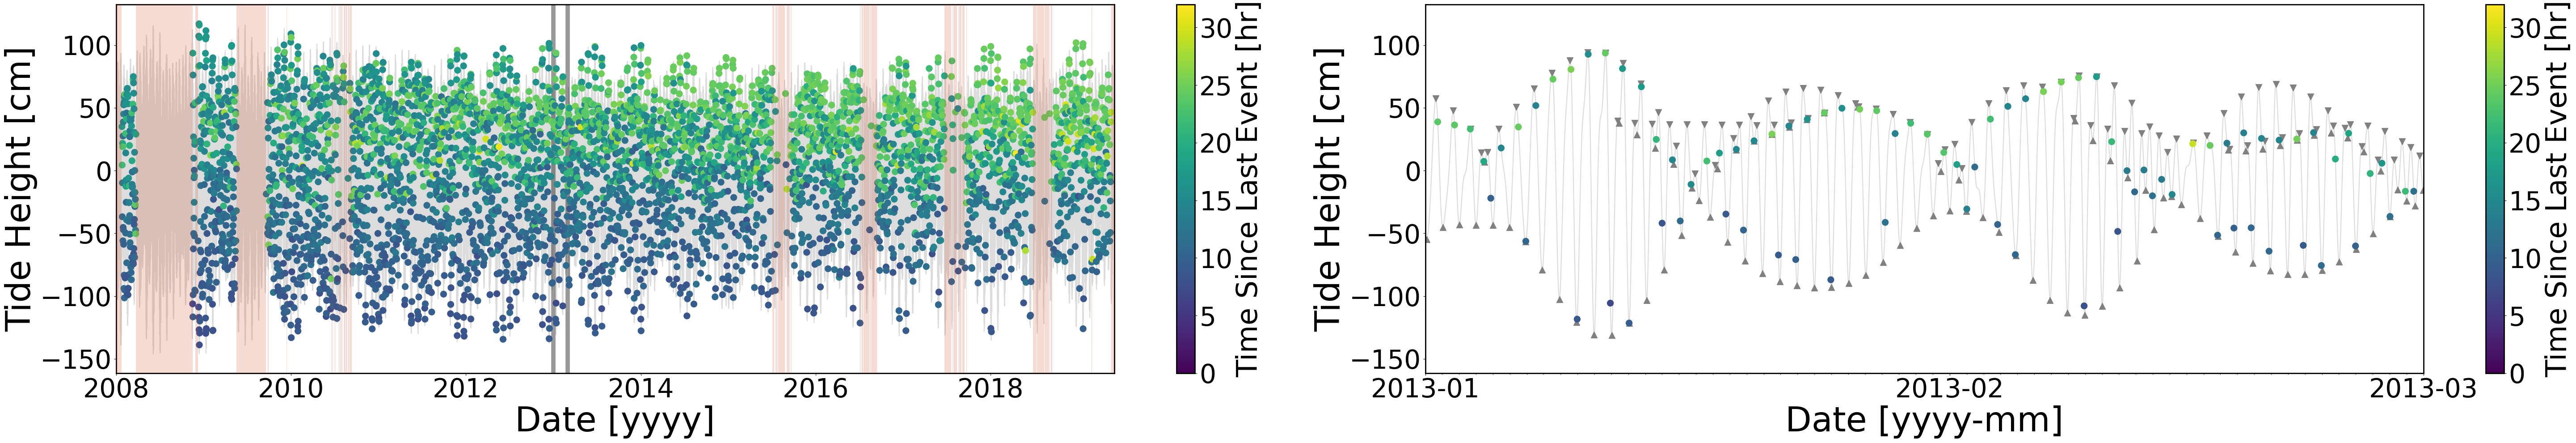

In [22]:
# FIGURE 3
# Plot tides to see trends with diurnal tides
def subplot(ax, place, dist, st, ed, triangles=False):
    """Subplot for Figure 3. Plots tides and events colored by time since last event

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        Axis to plot on
    place : str
        Place tides are modeled at
    dist : dict
        Dict of high and low tides
    st : datetime.datetime
        Start time of panel
    ed : datetime.datetime
        End time of panel;
    triangles : bool, optional
        Flag to plot low and high tide triangles. Default is False.
    """
    ax.plot(dates_timeseries, ev_data[f"tides{place}"], zorder=0, color="gainsboro")
    if triangles:
        ax.scatter(
            dist["pk_date"], dist["pk_tide"], zorder=0, color="gray", marker="v", s=100
        )
        ax.scatter(
            dist["vly_date"],
            dist["vly_tide"],
            zorder=0,
            color="gray",
            marker="^",
            s=100,
        )
    hr_since_last_ev = [
        (a.days * 24 * 3600 + a.seconds) / 3600 for a in ev_data["time_since_last_ev"]
    ]
    masked_hr = np.ma.masked_where(np.array(hr_since_last_ev) > 32, ev_data["ev_time"])
    cax = ax.scatter(
        masked_hr,
        ev_data[f"tide_event_time_{place}"],
        c=hr_since_last_ev,
        zorder=2,
        cmap="viridis",
        vmin=0,
        vmax=32,
        s=100,
    )
    cbar = plt.colorbar(cax)
    cbar.set_label("Time Since Last Event [hr]", size=46)
    cbar.ax.tick_params(labelsize=42)
    ax.set_xlim(st, ed)
    # ax.set_xlim(datetime.datetime(2012,12,8),datetime.datetime(2013,5,20))
    ax.set_xlabel("Date [yyyy]", size=55)
    if triangles:
        ax.set_xlabel("Date [yyyy-mm]", size=55)
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.set_ylabel("Tide Height [cm]", size=55)
    ax.xaxis.set_tick_params(labelsize=42)
    ax.yaxis.set_tick_params(labelsize=42)

    for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
        start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        rect = plt.Rectangle(
            (start, -200), interval, 1000, facecolor="#D34B29", alpha=0.1, zorder=3
        )
        ax1.add_patch(rect)

    # ax.set_title(f'{place} Tide Reference',size=20)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[60, 10])
st = datetime.datetime(2007, 12, 1)
ed = datetime.datetime(2019, 6, 17)

st = datetime.datetime(2008, 1, 1)
ed = datetime.datetime(2019, 6, 1)

subplot(ax1, "gz05", dist_gz05, st, ed, triangles=False)
st = datetime.datetime(2013, 1, 1)
ed = datetime.datetime(2013, 3, 1)
rect = plt.Rectangle(
    (st, -200),
    ed - st,
    1000,
    facecolor="none",
    zorder=0,
    alpha=0.4,
    edgecolor="black",
    linewidth=7,
)
ax1.add_patch(rect)


subplot(ax2, "gz05", dist_gz05, st, ed, triangles=True)


fig.tight_layout()

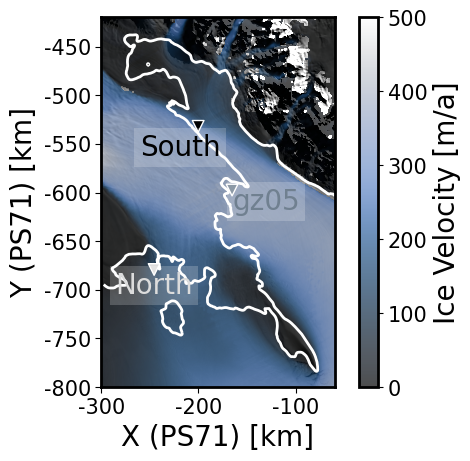

In [19]:
# Map
fig, ax0 = plt.subplots()
oslo = Colormap("crameri:oslo").to_mpl()
ax0.imshow(moa_dat, extent=ext, cmap="gray", vmin=15000, vmax=17000)
v = ax0.imshow(
    vel_mag,
    extent=(x_min_v, x_max_v, y_min_v, y_max_v),
    cmap=oslo,
    vmax=500,
    vmin=0,
    alpha=0.7,
)
for i, shape in enumerate(sf.shapes(bbox=bbox)):
    if i > 0:
        points = shape.points
        # Only get points within bounding box
        inbox = inBox(points, bbox)
        line = LineString(inbox)
        plot_line(line, ax=ax0, add_points=False, color="white")
x_min, x_max = bbox[0], bbox[2]
y_min, y_max = bbox[1], bbox[3]
ax0.set_xlim(x_min, x_max)
ax0.set_ylim(y_min, y_max)
KM_SCALE = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
ax0.xaxis.set_major_formatter(ticks_x)
ticks_y = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
ax0.yaxis.set_major_formatter(ticks_y)
ax0.set_xlabel("X (PS71) [km]", size=20)
ax0.set_ylabel("Y (PS71) [km]", size=20)
ax0.tick_params(labelsize=15)
ax0.tick_params(size=4)
# ax.set_facecolor("black")
cbarv = fig.colorbar(v)
cbarv.ax.tick_params(labelsize=15)
cbarv.ax.set_ylabel("Ice Velocity [m/a]", size=20)

lats = [-84.2986, y_north, y_south]
lons = [-164.5206, x_north, x_south]
places = ["gz05", "North", "South"]

x, y = ll2xy(lons, lats)
colors = ["slategray", "gainsboro", "black"]
ax0.scatter(x, y, s=70, color=colors, marker="v", edgecolors="white")
t = ax0.text(x[0], y[0] - 20000, "gz05", color=colors[0], size=20)
t.set_bbox(dict(facecolor="white", alpha=0.2, linewidth=0))
t = ax0.text(x[1] - 40000, y[1] - 25000, "North", color=colors[1], size=20)
t.set_bbox(dict(facecolor="white", alpha=0.2, linewidth=0))
t = ax0.text(x[2] - 60000, y[2] - 30000, "South", color=colors[2], size=20)
t.set_bbox(dict(facecolor="white", alpha=0.2, linewidth=0))

In [ ]:
# Extract coordinates of grounding line
from shapely.geometry import LineString
from shapely.plotting import plot_line, plot_polygon

# Results in arrays x_tide and y_tide, the x and y positions to calculated
# grounding zone tides at. (Red dots in figure). Converted to lons and lats and
# grouped as points in array lon_lats.
# Creates polygons shelf, rumples, and island for use to determine if points are
# on floating or grounded ice.

# Importing grounding line and conversion to shapely adapted from
# https://gis.stackexchange.com/questions/113799/reading-shapefile-in-python

# Tuning parameters
offset = 5000  # Distance from grounding line to offset, m
pt_dist = 500  # Distance between tide sampling points, m

# Arrays to pass to tides
x_tide = []
y_tide = []

bbox = [-300000, -800000, -60000, -420000]  # Includes all of Crary
fig, ax = plt.subplots(
    figsize=[(bbox[2] - bbox[0]) / 100000 * 3, (bbox[3] - bbox[1]) / 100000 * 3]
)
gl_path = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/Antarctica_masksX/scripps_antarctica_polygons_v1.shp"
sf = shapefile.Reader(gl_path)
for i, shape in enumerate(sf.shapes(bbox=bbox)):
    if i > 0:
        points = shape.points
        # Only get points within bounding box
        inbox = inBox(points, bbox)
        line = LineString(inbox)
        offset_line = line.offset_curve(offset)
        plot_line(offset_line, ax=ax, add_points=False, color="gray")

        interpolated = interpolateLine(offset_line, pt_dist)
        xs = [point.x for point in interpolated]
        ys = [point.y for point in interpolated]
        ax.scatter(xs, ys, s=1, color="red")
        x_tide.append(xs)
        y_tide.append(ys)

        if len(inbox) > 1000:  # Check if main array, not an island
            x, y = line.xy
            border = LineString(
                [
                    [x[0], y[0]],
                    [-50000, -600000],
                    [-50000, -800000],
                    [-300000, -800000],
                    [-300000, -700000],
                    [x[-1], y[-1]],
                ]
            )
            polygon = shapely.polygonize([line, border])
            shelf = polygon.geoms[0]
            plot_polygon(
                shelf,
                ax=ax,
                add_points=False,
                edgecolor="black",
                facecolor="white",
                alpha=0.7,
            )
        else:
            polygon = shapely.polygonize([line])
            if len(inbox) < 100:
                rumples = polygon.geoms[0]
                plot_polygon(rumples, ax=ax, add_points=False, color="black")
            else:
                island = polygon.geoms[0]
                plot_polygon(island, ax=ax, add_points=False, color="black")

ax.xaxis.set_major_locator(ticker.MultipleLocator(50000))
ax.yaxis.set_major_locator(ticker.MultipleLocator(50000))
ax.set_xlabel("X [m]", size=20)
ax.set_ylabel("Y [m]", size=20)
ax.tick_params(labelsize=15)

# Flatten the list. Not sure why this works but here's the source
# https://www.scaler.com/topics/flatten-list-python/
x_tide = sum(x_tide, [])
y_tide = sum(y_tide, [])

lon_lats = [xy2ll(x0, y0) for x0, y0 in zip(x_tide, y_tide)]
lons = [x[0] for x in lon_lats]
lats = [x[1] for x in lon_lats]
print(lon_lats)

In [ ]:
# Setup parameters
import pyTMD
import timescale

(year1, month1, day1) = (2019, 3, 30)  # First day of gz_05 data
# Calcluate date since Jan 1, 1992 [The format pyTMD wants it in]
# minutes = np.arange(7 * 3 * 1440) # Calcuate tides every minute for 2 weeks
hours = np.arange(1 * 24 * 2)  # Calcuate tides every minute for 2 weeks
plot_t = np.arange(
    datetime.datetime(2019, 3, 30),
    datetime.datetime(2020, 3, 30),
    datetime.timedelta(hours=0.5),
).astype(datetime.datetime)
tide_time = timescale.time.convert_calendar_dates(year1, month1, day1, hour=hours / 2)

print(len(tide_time))
print(len(plot_t))


# Setup model
dir = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background"
mod = "CATS2008-v2023"
model = pyTMD.io.model(dir, format="netcdf").elevation(mod)
print(model.format)
constituents = pyTMD.io.OTIS.read_constants(
    model.grid_file,
    model.model_file,
    model.projection,
    type=model.type,
    grid=model.format,
)
c = constituents.fields

# CALCULATE TIDES ALONG BASIN #
DELTAT = np.zeros_like(tide_time)
amp, ph, D = pyTMD.io.OTIS.interpolate_constants(
    np.atleast_1d(lons),
    np.atleast_1d(lats),
    constituents,
    model.projection,
    type=model.type,
    method="spline",
    extrapolate=True,
)
# calculate complex phase in radians for Euler's
cph = -1j * ph * np.pi / 180.0
# calculate constituent oscillation
hc = amp * np.exp(cph)

In [18]:
tides_new = []
for i in range(len(tide_time)):
    TIDE = pyTMD.predict.map(
        tide_time[i], hc, c, deltat=DELTAT[i], corrections=model.format
    )
    MINOR = pyTMD.predict.infer_minor(
        tide_time[i], hc, c, deltat=DELTAT[i], corrections=model.format
    )
    TIDE.data[:] += MINOR.data[:]
    # convert to centimeters
    TIDE.data[:] *= 100.0
    tides_new.append(TIDE.data)

In [19]:
def subplotS3(ax, place, dist, st, ed, color, triangles=False):
    """Subplot for Figure 3. Plots tides and events colored by time since last event

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        Axis to plot on
    place : str
        Place tides are modeled at
    dist : dict
        Dict of high and low tides
    st : datetime.datetime
        Start time of panel
    ed : datetime.datetime
        End time of panel;
    triangles : bool, optional
        Flag to plot low and high tide triangles. Default is False.
    """
    if triangles:
        ax.scatter(dist["pk_date"], dist["pk_tide"], zorder=0, color="gray", marker="v")
        ax.scatter(
            dist["vly_date"], dist["vly_tide"], zorder=0, color="gray", marker="^"
        )
    hr_since_last_ev = [
        (a.days * 24 * 3600 + a.seconds) / 3600 for a in ev_data["time_since_last_ev"]
    ]
    masked_hr = np.ma.masked_where(np.array(hr_since_last_ev) > 32, ev_data["ev_time"])
    cax = ax.scatter(
        masked_hr,
        ev_data[f"tide_event_time_{place}"],
        c=hr_since_last_ev,
        zorder=2,
        cmap="viridis",
        vmin=0,
        vmax=32,
        s=100,
    )
    ax.set_xlim(st, ed)
    # ax.set_xlim(datetime.datetime(2012,12,8),datetime.datetime(2013,5,20))
    ax.set_xlabel("Date [yyyy]", size=22)
    if triangles:
        ax.set_xlabel("Date [yyyy-mm-dd]", size=30)

    ax.set_ylabel("Tide Height [cm]", size=22)
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)

    for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
        start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        rect = plt.Rectangle(
            (start, -200), interval, 1000, facecolor="black", alpha=0.1, zorder=3
        )
        ax1.add_patch(rect)
    return cax

In [ ]:
# Static frame
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

bbox = [-300000, -800000, -60000, -420000]  # Includes all of Crary
gl_path = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/Antarctica_masksX/scripps_antarctica_polygons_v1.shp"
sf = shapefile.Reader(gl_path)
fig, ax = plt.subplots(
    figsize=[(bbox[2] - bbox[0]) / 100000 * 5, (bbox[3] - bbox[1]) / 100000 * 3],
    constrained_layout=True,
)
ax.imshow(moa_dat, extent=ext, cmap="gray", vmin=15000, vmax=17000)
v = ax.imshow(
    vel_mag,
    extent=(x_min_v, x_max_v, y_min_v, y_max_v),
    cmap=oslo,
    vmax=500,
    vmin=0,
    alpha=0.7,
)
tide = ax.scatter(x_tide, y_tide, c=tides_new[3], vmax=100, vmin=-100, cmap="PiYG_r")
for i, shape in enumerate(sf.shapes(bbox=bbox)):
    if i > 0:
        points = shape.points
        # Only get points within bounding box
        inbox = inBox(points, bbox)
        line = LineString(inbox)
        plot_line(line, ax=ax, add_points=False, color="black")
x_min, x_max = bbox[0], bbox[2]
y_min, y_max = bbox[1], bbox[3]
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
KM_SCALE = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_xlabel("X (PS71) [km]", size=30)
ax.set_ylabel("Y (PS71) [km]", size=30)
ax.tick_params(labelsize=25)
ax.tick_params(size=4)
# ax.set_facecolor("black")
# Place colorbar in top right of figur
# Adapted from
# https://stackoverflow.com/questions/35950559/add-a-white-background-to-colorbar-in-matplotlib


cbaxes = inset_axes(ax, width="40%", height="10%", loc="upper right")
[cbaxes.spines[k].set_visible(False) for k in cbaxes.spines]
cbaxes.tick_params(
    axis="both",
    left=False,
    top=False,
    right=False,
    bottom=False,
    labelleft=False,
    labeltop=False,
    labelright=False,
    labelbottom=False,
)
cbaxes.set_facecolor([0, 0, 0, 0.5])
cbbox = inset_axes(cbaxes, width="80%", height="16%", loc="center")
cbarv = fig.colorbar(v, cax=cbbox, orientation="horizontal")
cbarv.outline.set_edgecolor("white")
cbarv.ax.tick_params(labelsize=18, color="white", labelcolor="white")
cbarv.ax.set_xlabel("Ice Velocity [m a$^{-1}$]", size=18, color="white", labelpad=-58)

cbaramp = fig.colorbar(tide)
cbaramp.ax.tick_params(labelsize=25)
cbaramp.ax.set_ylabel("Tidal Amplitude [cm]", size=30)

lats = [-84.2986, y_north, y_south]
lons = [-164.5206, x_north, x_south]
places = ["gz05", "North", "South"]

x, y = ll2xy(lons, lats)
colors = ["#edb3a5", "#a03820", "black"]
ax.scatter(x, y, s=170, color=colors, marker="v", edgecolors="black")
t = ax.text(x[0] + 5000, y[0] - 15000, "GZ05", color=colors[0], size=30)
t.set_bbox(dict(facecolor="white", alpha=0.2, linewidth=0))
t = ax.text(x[1] - 20000, y[1] - 20000, "North", color=colors[1], size=30)
t.set_bbox(dict(facecolor="white", alpha=0.2, linewidth=0))
t = ax.text(x[2] - 45000, y[2] - 15000, "South", color=colors[2], size=30)
t.set_bbox(dict(facecolor="white", alpha=0.2, linewidth=0))

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, y)
cbaxes = inset_axes(ax, width="30%", height="3%", loc="upper right")
cbaxes.set_facecolor("green")
cbarv = fig.colorbar(v, cax=cbaxes, orientation="horizontal")
# Set inset axes background color\\

a = np.random.rand(10, 10)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
im = ax.imshow(a)

cbbox = inset_axes(ax, "15%", "90%", loc=7)
[cbbox.spines[k].set_visible(False) for k in cbbox.spines]
cbbox.tick_params(
    axis="both",
    left="off",
    top="off",
    right="off",
    bottom="off",
    labelleft="off",
    labeltop="off",
    labelright="off",
    labelbottom="off",
)
cbbox.set_facecolor([1, 1, 1, 0.7])

cbaxes = inset_axes(cbbox, "30%", "95%", loc=6)

cb = fig.colorbar(im, cax=cbaxes)  # make colorbar

In [ ]:
# Just the timeseries
fig, ax2 = plt.subplots(figsize=[18, 8])

st = datetime.datetime(2013, 3, 12, 6)
ed = datetime.datetime(2013, 3, 21, 18)

ax2.plot(
    dates_timeseries,
    ev_data["tidesSouth"],
    zorder=0,
    color=colors[2],
    label="South",
    linewidth=2,
)
ax2.plot(
    dates_timeseries,
    ev_data["tidesgz05"],
    zorder=0,
    color=colors[0],
    label="GZ05",
    linewidth=2,
)
ax2.plot(
    dates_timeseries,
    ev_data["tidesNorth"],
    zorder=0,
    color=colors[1],
    label="North",
    linewidth=2,
)

cax = subplotS3(ax2, "gz05", dist_gz05, st, ed, colors[0], triangles=True)
cax = subplotS3(ax2, "North", dist_North, st, ed, colors[1], triangles=True)
cax = subplotS3(ax2, "South", dist_South, st, ed, colors[2], triangles=True)
cbar = plt.colorbar(cax)  # location='bottom',shrink=0.4)
cbar.set_label("Time Since Last Event [hr]", size=28)
cbar.ax.tick_params(labelsize=25)

ax2.set_ylabel("Tide Height [cm]", size=30)
for i, label in enumerate(ax2.get_xticklabels()):
    label.set_visible(i % 2 == 0)
ax2.legend(fontsize=25)

ax2.set_ylim(-125, 125)

ax2.tick_params(labelsize=25)

In [ ]:
# FIGURE S3
# Overall size based on map aspect
fig = plt.figure(figsize=[16, 16])
gs = mpl.gridspec.GridSpec(6, 6, wspace=2, hspace=0.6)
ax0 = fig.add_subplot(gs[0:3, 0:3])
ax1 = fig.add_subplot(gs[0:3, 3:5], aspect="equal")
ax2 = fig.add_subplot(gs[3:5, 0:6])
cbar_ax = fig.add_subplot(gs[0:3, 2])
cbar_ax.axis("off")

# Map
oslo = Colormap("crameri:oslo").to_mpl()
ax0.imshow(moa_dat, extent=ext, cmap="gray", vmin=15000, vmax=17000)
v = ax0.imshow(
    vel_mag,
    extent=(x_min_v, x_max_v, y_min_v, y_max_v),
    cmap=oslo,
    vmax=500,
    vmin=0,
    alpha=0.7,
)
for i, shape in enumerate(sf.shapes(bbox=bbox)):
    if i > 0:
        points = shape.points
        # Only get points within bounding box
        inbox = inBox(points, bbox)
        line = LineString(inbox)
        plot_line(line, ax=ax0, add_points=False, color="white")
x_min, x_max = bbox[0], bbox[2]
y_min, y_max = bbox[1], bbox[3]
ax0.set_xlim(x_min, x_max)
ax0.set_ylim(y_min, y_max)
KM_SCALE = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
ax0.xaxis.set_major_formatter(ticks_x)
ticks_y = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
ax0.yaxis.set_major_formatter(ticks_y)
ax0.set_xlabel("X (PS71) [km]", size=20)
ax0.set_ylabel("Y (PS71) [km]", size=20)
ax0.tick_params(labelsize=15)
ax0.tick_params(size=4)
# ax.set_facecolor("black")
cbarv = fig.colorbar(v)
cbarv.ax.tick_params(labelsize=15)
cbarv.ax.set_ylabel("Ice Velocity [m/a]", size=20)

lats = [-84.2986, y_north, y_south]
lons = [-164.5206, x_north, x_south]
places = ["gz05", "North", "South"]

x, y = ll2xy(lons, lats)
colors = ["#edb3a5", "#D34B29", "black"]
ax0.scatter(x, y, s=70, color=colors, marker="v", edgecolors="white")
t = ax0.text(x[0], y[0] - 25000, "GZ05", color=colors[0], size=20)
t.set_bbox(dict(facecolor="white", alpha=0.2, linewidth=0))
t = ax0.text(x[1] - 25000, y[1] - 25000, "North", color=colors[1], size=20)
t.set_bbox(dict(facecolor="white", alpha=0.2, linewidth=0))
t = ax0.text(x[2] - 60000, y[2] - 25000, "South", color=colors[2], size=20)
t.set_bbox(dict(facecolor="white", alpha=0.2, linewidth=0))


# Scatterplot
hr_since_last_ev = [
    (a.days * 24 * 3600 + a.seconds) / 3600 for a in ev_data["time_since_last_ev"]
]
masked_hr = np.ma.masked_where(np.array(hr_since_last_ev) > 32, ev_data["ev_time"])
cax = ax1.scatter(
    ev_data["tide_event_time_South"],
    ev_data["tide_event_time_North"],
    c=hr_since_last_ev,
    zorder=2,
    cmap="viridis",
    vmin=0,
    vmax=32,
)

ax1.set_xlabel("Tide at South [cm]", size=20)
ax1.set_ylabel("Tide at North [cm]", size=20)
ax1.set_xlim(-150, 150)
ax1.set_ylim(-150, 150)
x = np.arange(-150, 250, 150)
y = np.arange(-150, 250, 150)
ax1.plot(y, x, "red")
ax1.tick_params(labelsize=15)
ax1.tick_params(size=4)

st = datetime.datetime(2013, 3, 12)
ed = datetime.datetime(2013, 3, 22)

ax2.plot(
    dates_timeseries, ev_data["tidesSouth"], zorder=0, color=colors[2], label="South"
)
ax2.plot(
    dates_timeseries, ev_data["tidesgz05"], zorder=0, color=colors[0], label="GZ05"
)
ax2.plot(
    dates_timeseries, ev_data["tidesNorth"], zorder=0, color=colors[1], label="North"
)

cax = subplotS3(ax2, "gz05", dist_gz05, st, ed, colors[0], triangles=True)
cax = subplotS3(ax2, "North", dist_North, st, ed, colors[1], triangles=True)
cax = subplotS3(ax2, "South", dist_South, st, ed, colors[2], triangles=True)
cbar = plt.colorbar(cax)
cbar.set_label("Time Since Last Event [hr]", size=22)
cbar.ax.tick_params(labelsize=18)

ax2.set_ylabel("Tide Height [cm]", size=20)
for i, label in enumerate(ax2.get_xticklabels()):
    label.set_visible(i % 2 == 0)
ax2.legend()
ax2.set_ylim(-125, 125)

In [23]:
# Find time since last event for all skipped low tides
time_since_last_event_low_pk = []
time_to_next_event_low_pk = []

events = np.ma.masked_where(
    np.array(dist_gz05["high_closers"]) == 1, ev_data["ev_time"]
)
events = np.ma.compressed(events)
tide_low = np.ma.masked_where(
    np.array(dist_gz05["high_closers"]) == 1, ev_data["tide_event_time_gz05"]
)
tide_low = np.ma.compressed(tide_low)

for i, valley in enumerate(dist_gz05["vly_date"]):
    closest_event = min(
        events,
        key=lambda d: abs(datetime.datetime.strptime(d, "%Y-%m-%d %H:%M:%S") - valley),
    )
    if datetime.datetime.strptime(closest_event, "%Y-%m-%d %H:%M:%S") > valley:
        closest_event = events[np.where(events == closest_event)[0] - 1][0]
    time_since_last_event_low_pk.append(
        valley - datetime.datetime.strptime(closest_event, "%Y-%m-%d %H:%M:%S")
    )

    closest_event = min(
        events,
        key=lambda d: abs(datetime.datetime.strptime(d, "%Y-%m-%d %H:%M:%S") - valley),
    )
    if datetime.datetime.strptime(closest_event, "%Y-%m-%d %H:%M:%S") < valley:
        try:
            closest_event = events[np.where(events == closest_event)[0] + 1][0]
        except IndexError:
            pass
    time_to_next_event_low_pk.append(
        datetime.datetime.strptime(closest_event, "%Y-%m-%d %H:%M:%S") - valley
    )

In [24]:
def rolling_average(
    window,
    slide_len,
    time_since_last_event_low_pk,
    time_to_next_event_low_pk,
    dist_gz05,
    ev_data,
    no_data,
):
    """Rolling average of slip events.

    Parameters
    ----------
    window : int
        Days to average over
    slide_len : int
        Days to slide window
    time_since_last_event_low_pk : list
        Times since last event
    time_to_next_event_low_pk : list
        Time to next event
    dist_gz05 : dict
        Dict of high and low tides
    ev_data : dict
        Dict of event data
    no_data : dict
        Dict of no data times
    """
    # Compute rolling average of skipped low slips

    time_since_low_hr = [a.total_seconds() / 3600 for a in time_since_last_event_low_pk]
    time_to_low_hr = [a.total_seconds() / 3600 for a in time_to_next_event_low_pk]

    mask = []
    for ts, tt in zip(time_since_low_hr, time_to_low_hr):
        if ts < 6 or tt < 6:
            mask.append(1)
        else:
            mask.append(0)

    masked_low_skips = np.ma.masked_where(mask, dist_gz05["vly_date"])
    masked_low_skips = np.ma.compressed(masked_low_skips)

    dates_timeseries_avg = []
    initial_time = datetime.datetime.strptime(
        "2007-12-01 00:00:00", "%Y-%m-%d %H:%M:%S"
    )

    time_to_append = window  # Days
    slide = slide_len  # Days

    # assert time_to_append % slide == 0
    interval = int(time_to_append // slide)  # MUST BE AN INTEGER

    rng = int(12 * 365 // slide)  # Range of times
    for i in range(rng):
        dates_timeseries_avg.append(initial_time + datetime.timedelta(days=slide * i))

    skips = []
    skip_starts = []
    skip_ends = []
    skip_middles = []
    tot_slips = []
    spacings = []

    for i, date in enumerate(dates_timeseries_avg):
        if i > interval:
            interval_start = dates_timeseries_avg[i - interval]
            interval_end = date

            # print(interval_start,interval_end)
            last_ev = datetime.datetime.strptime(
                ev_data["ev_time"].iloc[-1], "%Y-%m-%d %H:%M:%S"
            )
            first_ev = datetime.datetime.strptime(
                ev_data["ev_time"].iloc[0], "%Y-%m-%d %H:%M:%S"
            )
            stop = False
            for start, end in zip(no_data["starts"], no_data["ends"]):
                start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
                end = datetime.datetime.strptime(end, "%Y-%m-%d %H:%M:%S")

                # Check that interval does not include gaps in data or start before 1st event or end after last event
                # if (interval_start > start and interval_start < end) or (interval_end > start and interval_end < end) \
                #    or (interval_start < end and interval_end > start) or (interval_start < start and interval_end > start) \
                #        or interval_start < first_ev \
                #        or interval_end > last_ev:
                #    stop = True

                if (
                    (interval_start < end and interval_end > start)
                    or interval_start < first_ev
                    or interval_end > last_ev
                ):
                    stop = True

            if not stop:
                # Number of total events
                slip = 0
                for event in ev_data["ev_time"]:
                    event = datetime.datetime.strptime(event, "%Y-%m-%d %H:%M:%S")
                    if event > interval_start and event < interval_end:
                        slip += 1

                # Number of low skips
                skip = 0
                for date_low in masked_low_skips:
                    if date_low > interval_start and date_low < interval_end:
                        skip += 1

                # Avg Event spacing
                spacing = 0
                counter = 0
                time_since = [
                    (a.days * 24 * 3600 + a.seconds) / 3600
                    for a in ev_data["time_since_last_ev"]
                ]
                for f, event in enumerate(ev_data["ev_time"]):
                    event = datetime.datetime.strptime(event, "%Y-%m-%d %H:%M:%S")
                    if event > interval_start and event < interval_end:
                        spacing += time_since[f]
                        counter += 1
                try:
                    spacing = spacing / counter
                except ZeroDivisionError:
                    spacing = np.nan
                # Avg Event amplitude

            else:
                skip = np.nan
                slip = np.nan
                spacing = np.nan

            skip_starts.append(interval_start)
            skip_ends.append(interval_end)
            skip_middles.append(interval_start + (interval_end - interval_start) / 2)
            skips.append(skip)
            tot_slips.append(slip)
            spacings.append(spacing)

    return skip_starts, skip_ends, skip_middles, skips, tot_slips, spacings

In [25]:
def annotation(ax, x1, x2, y1, y2, text):
    """Draws an annotated bracket."""
    xs = [x1, x1, x2, x2]
    ys = [y1, y2, y2, y1]
    ax.plot(xs, ys, "k-")
    ax.text((x2 - x1) / 2 + x1, y2 + 0.1, text, ha="center", va="bottom", fontsize=18)

In [26]:
slide = 1
rolling_avg_dicts = []
for window in [3, 27, 45]:
    skip_starts, skip_ends, skip_middles, skips, tot_slips, spacings = rolling_average(
        window,
        slide,
        time_since_last_event_low_pk,
        time_to_next_event_low_pk,
        dist_gz05,
        ev_data,
        no_data,
    )
    # Save as dict
    rolling_avg_dict = {
        "skip_starts": skip_starts,
        "skip_ends": skip_ends,
        "skip_middles": skip_middles,
        "skips": skips,
        "tot_slips": tot_slips,
        "spacings": spacings,
    }
    rolling_avg_dicts.append(rolling_avg_dict)

In [27]:
# Plotting function
def plot_rolling_avg_section(
    ax1,
    ax3,
    window,
    slide_len,
    skip_starts,
    skip_ends,
    skip_middles,
    skips,
    tot_slips,
    spacings,
):
    # Skipped slips by number of slips in xx period
    ax2 = ax1.twinx()
    (
        ax1.plot(
            dates_timeseries, ev_data["tidesgz05"], zorder=1, color="gray", alpha=0.4
        ),
    )
    for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
        start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        rect = plt.Rectangle(
            (start, -200), interval, 1000, facecolor="black", alpha=0.2, zorder=3
        )
        ax1.add_patch(rect)

    ax1.set_xlim(datetime.datetime(2008, 1, 1), datetime.datetime(2019, 6, 1))
    ax1.set_ylim(-120, 130)

    xerr = [(end - start) // 2 for start, end in zip(skip_starts, skip_ends)]
    norm_slips = [i / window for i in tot_slips]
    ax2.errorbar(skip_middles, norm_slips, xerr=xerr, fmt="o", color="black", zorder=2)
    # ax2.plot(skip_middles, tot_slips, color='blue')

    timestamps = [a.timestamp() for a in skip_middles]

    compressed_tot_slips = np.ma.masked_invalid(tot_slips)
    compressed_timestamps = np.ma.masked_where(
        np.ma.getmask(compressed_tot_slips), timestamps
    )
    compressed_tot_slips = np.ma.compressed(compressed_tot_slips)
    compressed_timestamps = np.ma.compressed(compressed_timestamps)

    coef = np.polyfit(compressed_timestamps, compressed_tot_slips, 1)
    print(coef)
    lst_sqrs_fit = np.poly1d(coef)
    print(lst_sqrs_fit[1])

    datetimes = [datetime.datetime.fromtimestamp(a) for a in compressed_timestamps]
    # ax2.plot(datetimes, lst_sqrs_fit(compressed_timestamps),color='blue',zorder=3)

    # Just a line so manually extract slope
    delta_y = (
        lst_sqrs_fit(compressed_timestamps)[-1] - lst_sqrs_fit(compressed_timestamps)[0]
    )
    delta_x = datetimes[-1] - datetimes[0]

    print(delta_y, delta_x)
    slope = delta_y / delta_x.total_seconds() * 3600 * 24 * 365
    print(slope)  # Slips / year
    ax1.yaxis.set_label_position("right")
    ax1.yaxis.tick_right()
    ax2.yaxis.set_label_position("left")
    ax2.yaxis.tick_left()
    ax1.set_xlabel("Date [yyyy]", size=22)
    ax1.set_ylabel("Tide Height [cm]", size=22)
    ax2.set_ylabel(f"Slips/Day [{window} Day Window]", size=22, color="black")
    ax1.xaxis.set_tick_params(labelsize=18)
    ax1.yaxis.set_tick_params(labelsize=18, color="gray")
    ax2.yaxis.set_tick_params(labelsize=18, colors="black")
    # ax2.spines['left'].set_color('red')

    ax4 = ax3.twinx()
    (
        ax3.plot(
            dates_timeseries, ev_data["tidesgz05"], zorder=1, color="gray", alpha=0.4
        ),
    )
    for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
        start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        rect = plt.Rectangle(
            (start, -200), interval, 1000, facecolor="black", alpha=0.2, zorder=3
        )
        ax3.add_patch(rect)

    st3 = datetime.datetime(2014, 1, 1)
    ed3 = datetime.datetime(2015, 6, 1)

    ax3.set_xlim(st3, ed3)
    # ax3.set_xlim(datetime.datetime(2008,12,8),datetime.datetime(2009,7,1))
    ax3.set_ylim(-155, 130)

    xerr = [(end - start) // 2 for start, end in zip(skip_starts, skip_ends)]
    # Segmet skipmiddles and norm_slips by date
    mask = [start > st3 and end < ed3 for start, end in zip(skip_middles, skip_ends)]
    skip_middles = np.array(skip_middles)[mask]
    norm_slips = np.array(norm_slips)[mask]
    xerr = np.array(xerr)[mask]

    ax4.errorbar(skip_middles, norm_slips, xerr=xerr, fmt="o", color="black", zorder=2)
    ax3.yaxis.set_label_position("right")
    ax3.yaxis.tick_right()
    ax4.yaxis.set_label_position("left")
    ax4.yaxis.tick_left()
    ax3.set_xlabel("Date [yyyy-mm]", size=22)
    ax3.set_ylabel("Tide Height [cm]", size=22)
    ax4.set_ylabel(f"Slips/Day [{window} Day Window]", size=22, color="black")
    ax3.xaxis.set_tick_params(labelsize=18)
    ax3.yaxis.set_tick_params(labelsize=18, color="gray")
    ax4.yaxis.set_tick_params(labelsize=18, colors="black")

    ssa_time = datetime.timedelta(days=182.63)
    ssa_start = datetime.datetime(2014, 3, 1)
    annotation(ax1, ssa_start, ssa_start + ssa_time, 92, 96, "$S_{sa}$")

    mm_time = datetime.timedelta(days=27.55)
    mm_start = datetime.datetime(2014, 6, 11)
    annotation(ax3, mm_start, mm_start + mm_time, 94, 98, "$M_{m}$")

    # ax1.set_title(f'{time_to_append} Day Rolling Average',size=22)

    ax1.set_title(f"{window} Day Window", size=22)
    # fig.tight_layout()

[-4.72210954e-09  1.09087618e+01]
-4.7221095431870305e-09
-1.684166812391097 4128 days, 0:00:00
-0.14891494344058875
27.574871966154536 Days, Power = 0.16214499626826087
14.769081693500299 Days, Power = 0.07828923321222668
13.682327919566902 Days, Power = 0.0732870284552016


/tmp/ipykernel_103736/4148681939.py:106: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


[-4.27633846e-08  9.84334903e+01]
-4.276338457238075e-08
-15.163126428443903 4104 days, 0:00:00
-1.3485724040891873
184.0340059790733 Days, Power = 0.3031840403211768
[-7.09428053e-08  1.63511547e+02]
-7.094280533625993e-08
-25.044711550882766 4086 days, 0:00:00
-2.2372294948781715
184.88499245852188 Days, Power = 0.3130367104740365
31.846908287866984 Days, Power = 0.0601659375960409
27.55197797257811 Days, Power = 0.1572578682649308


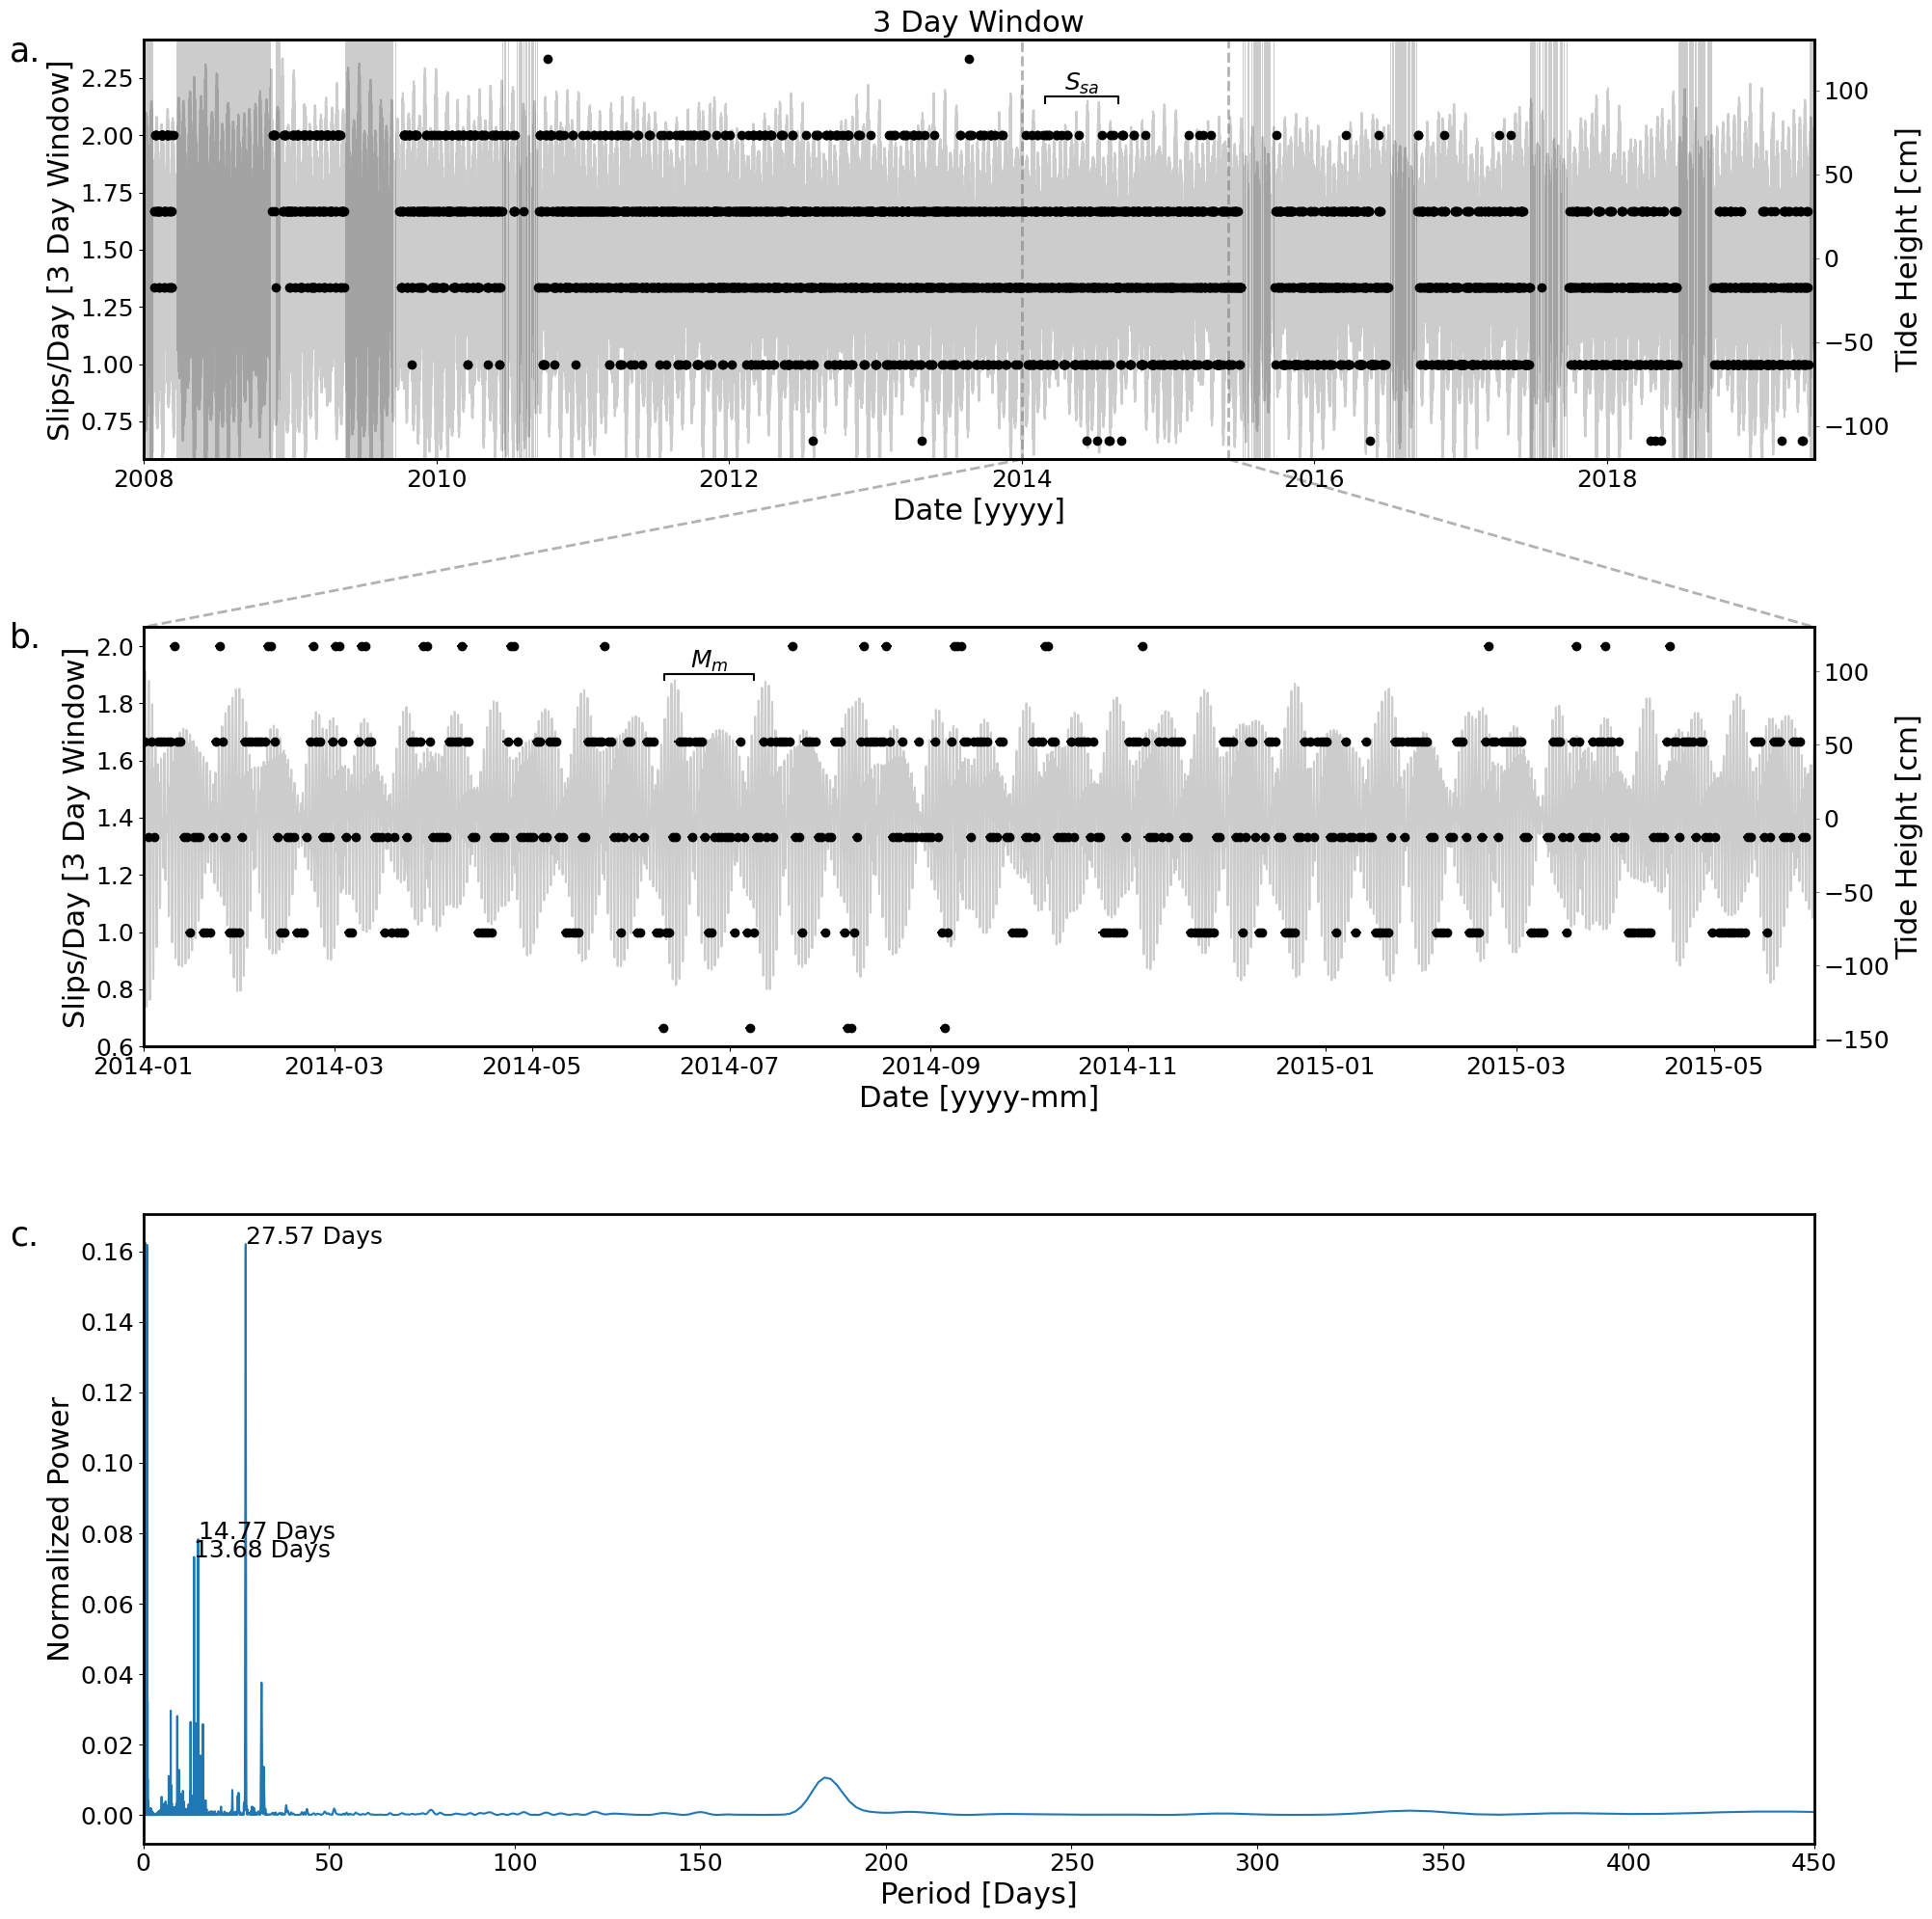

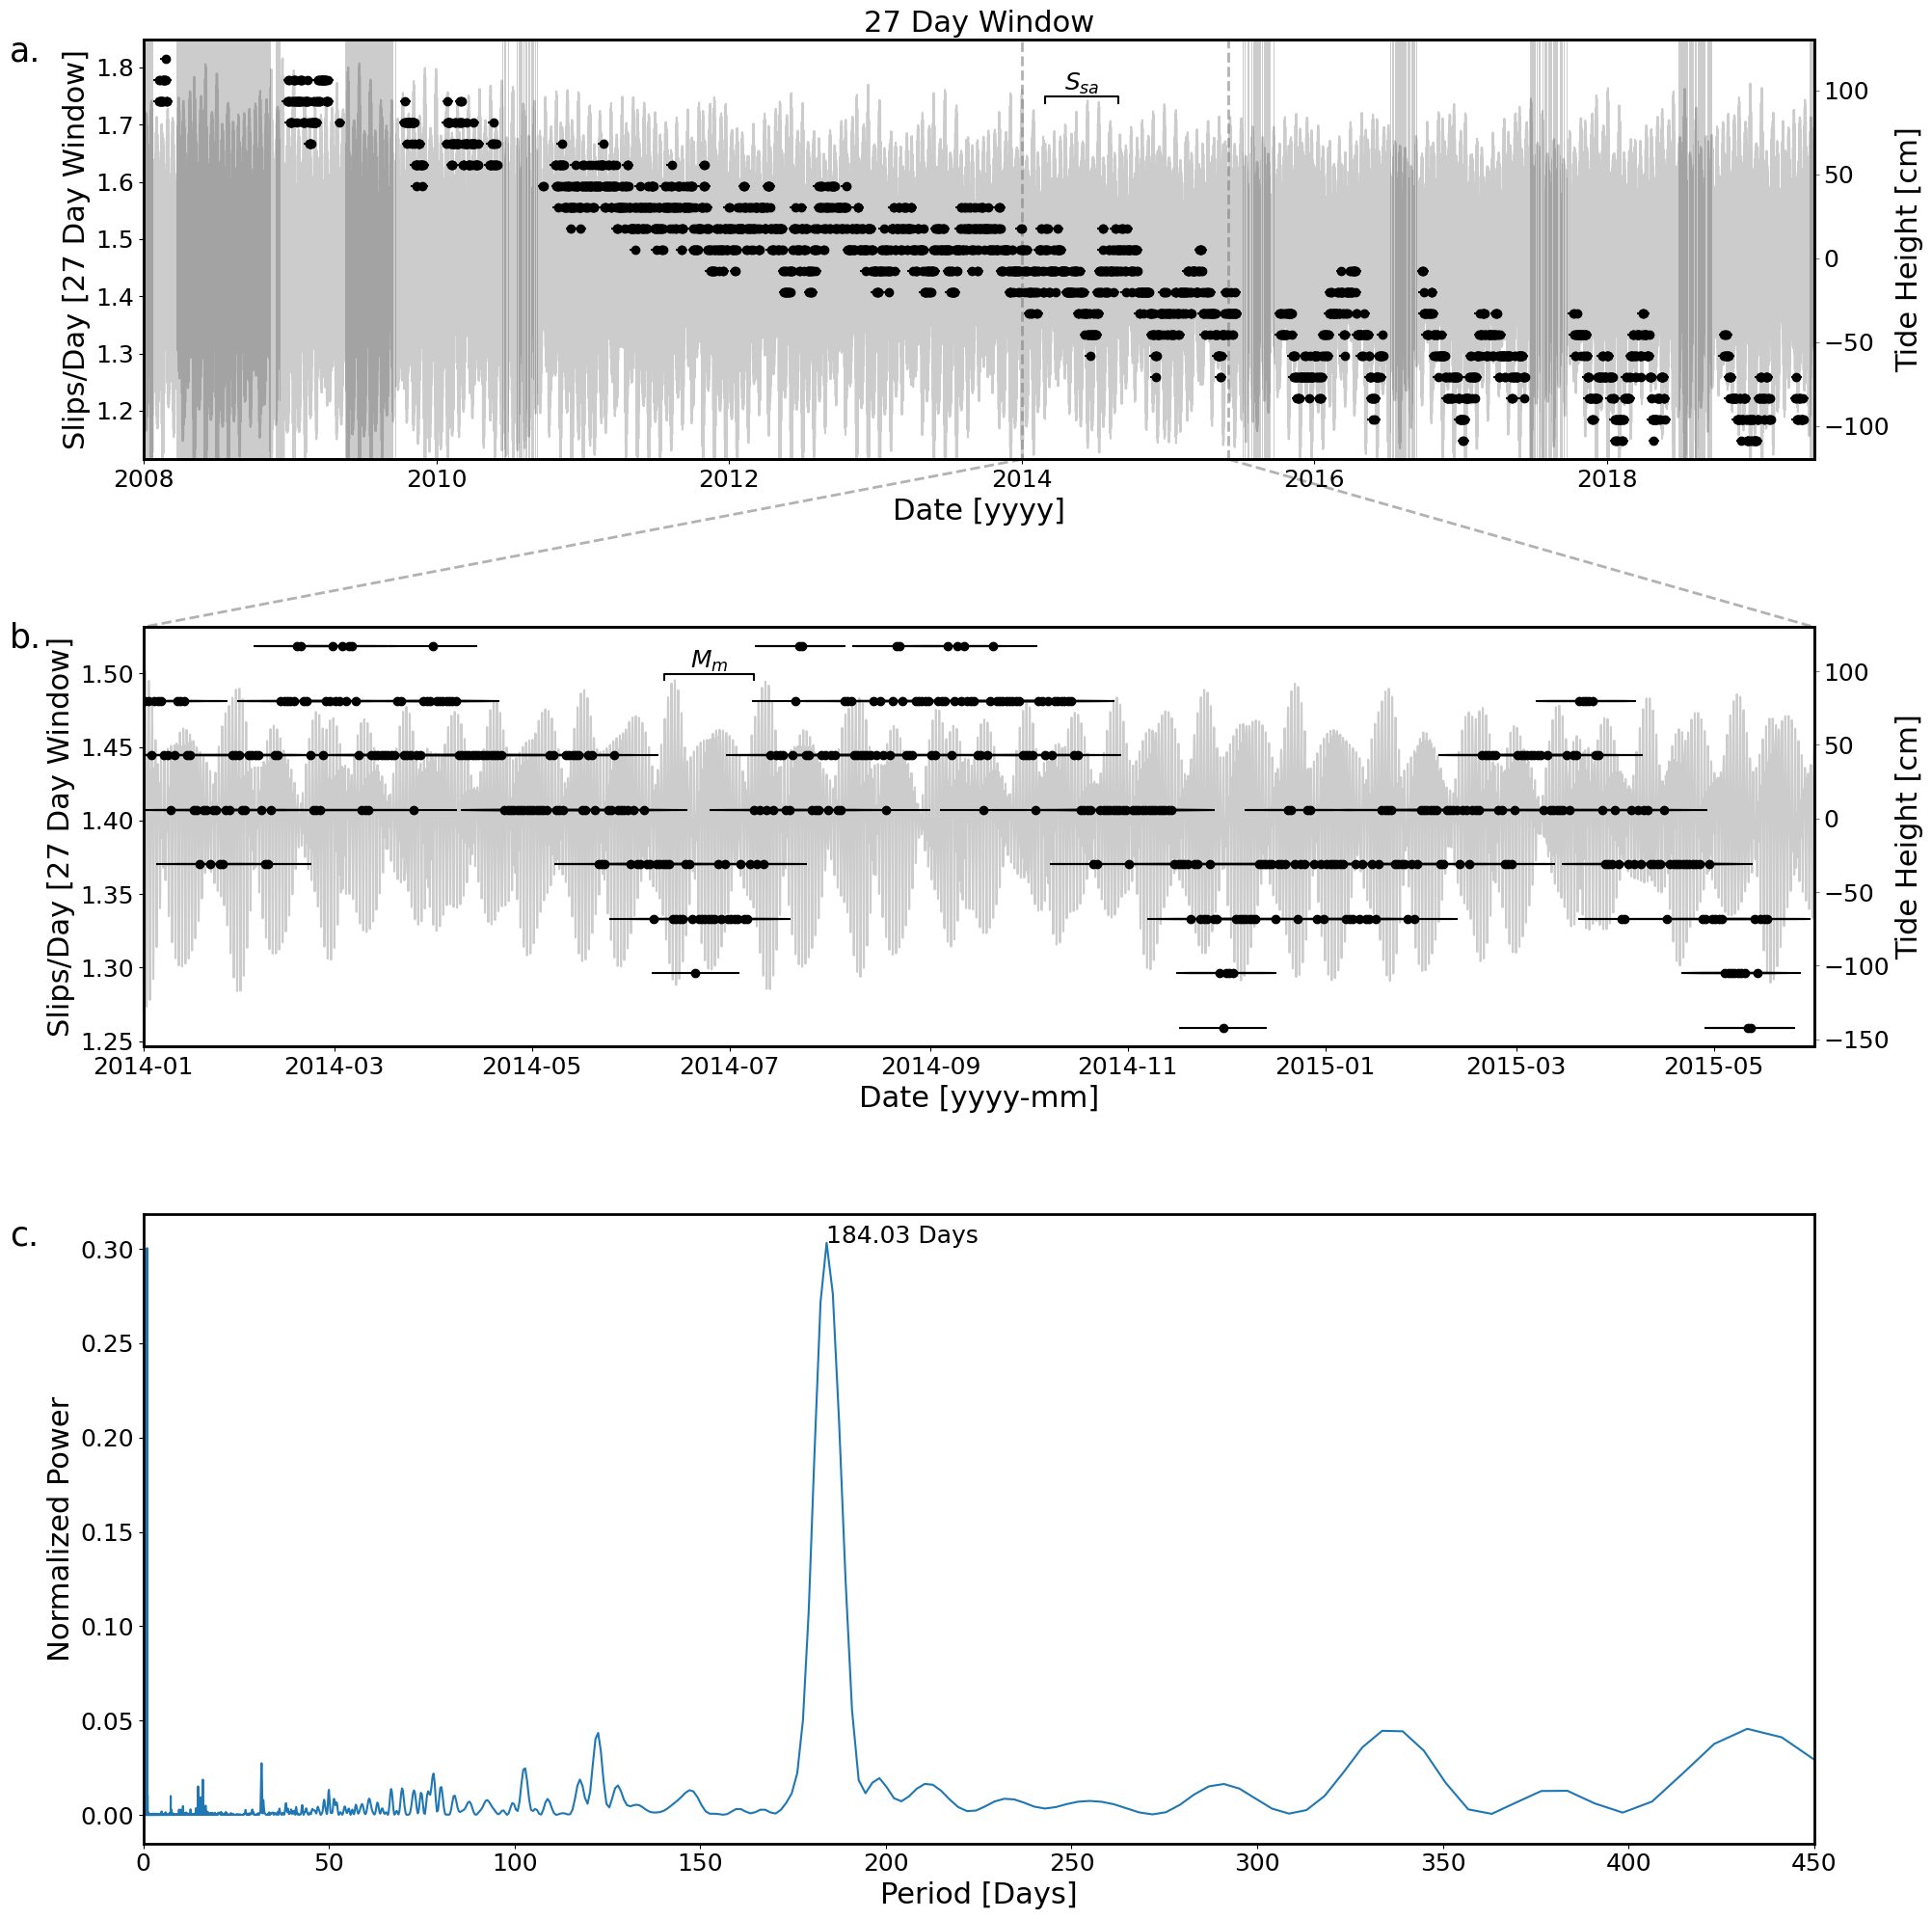

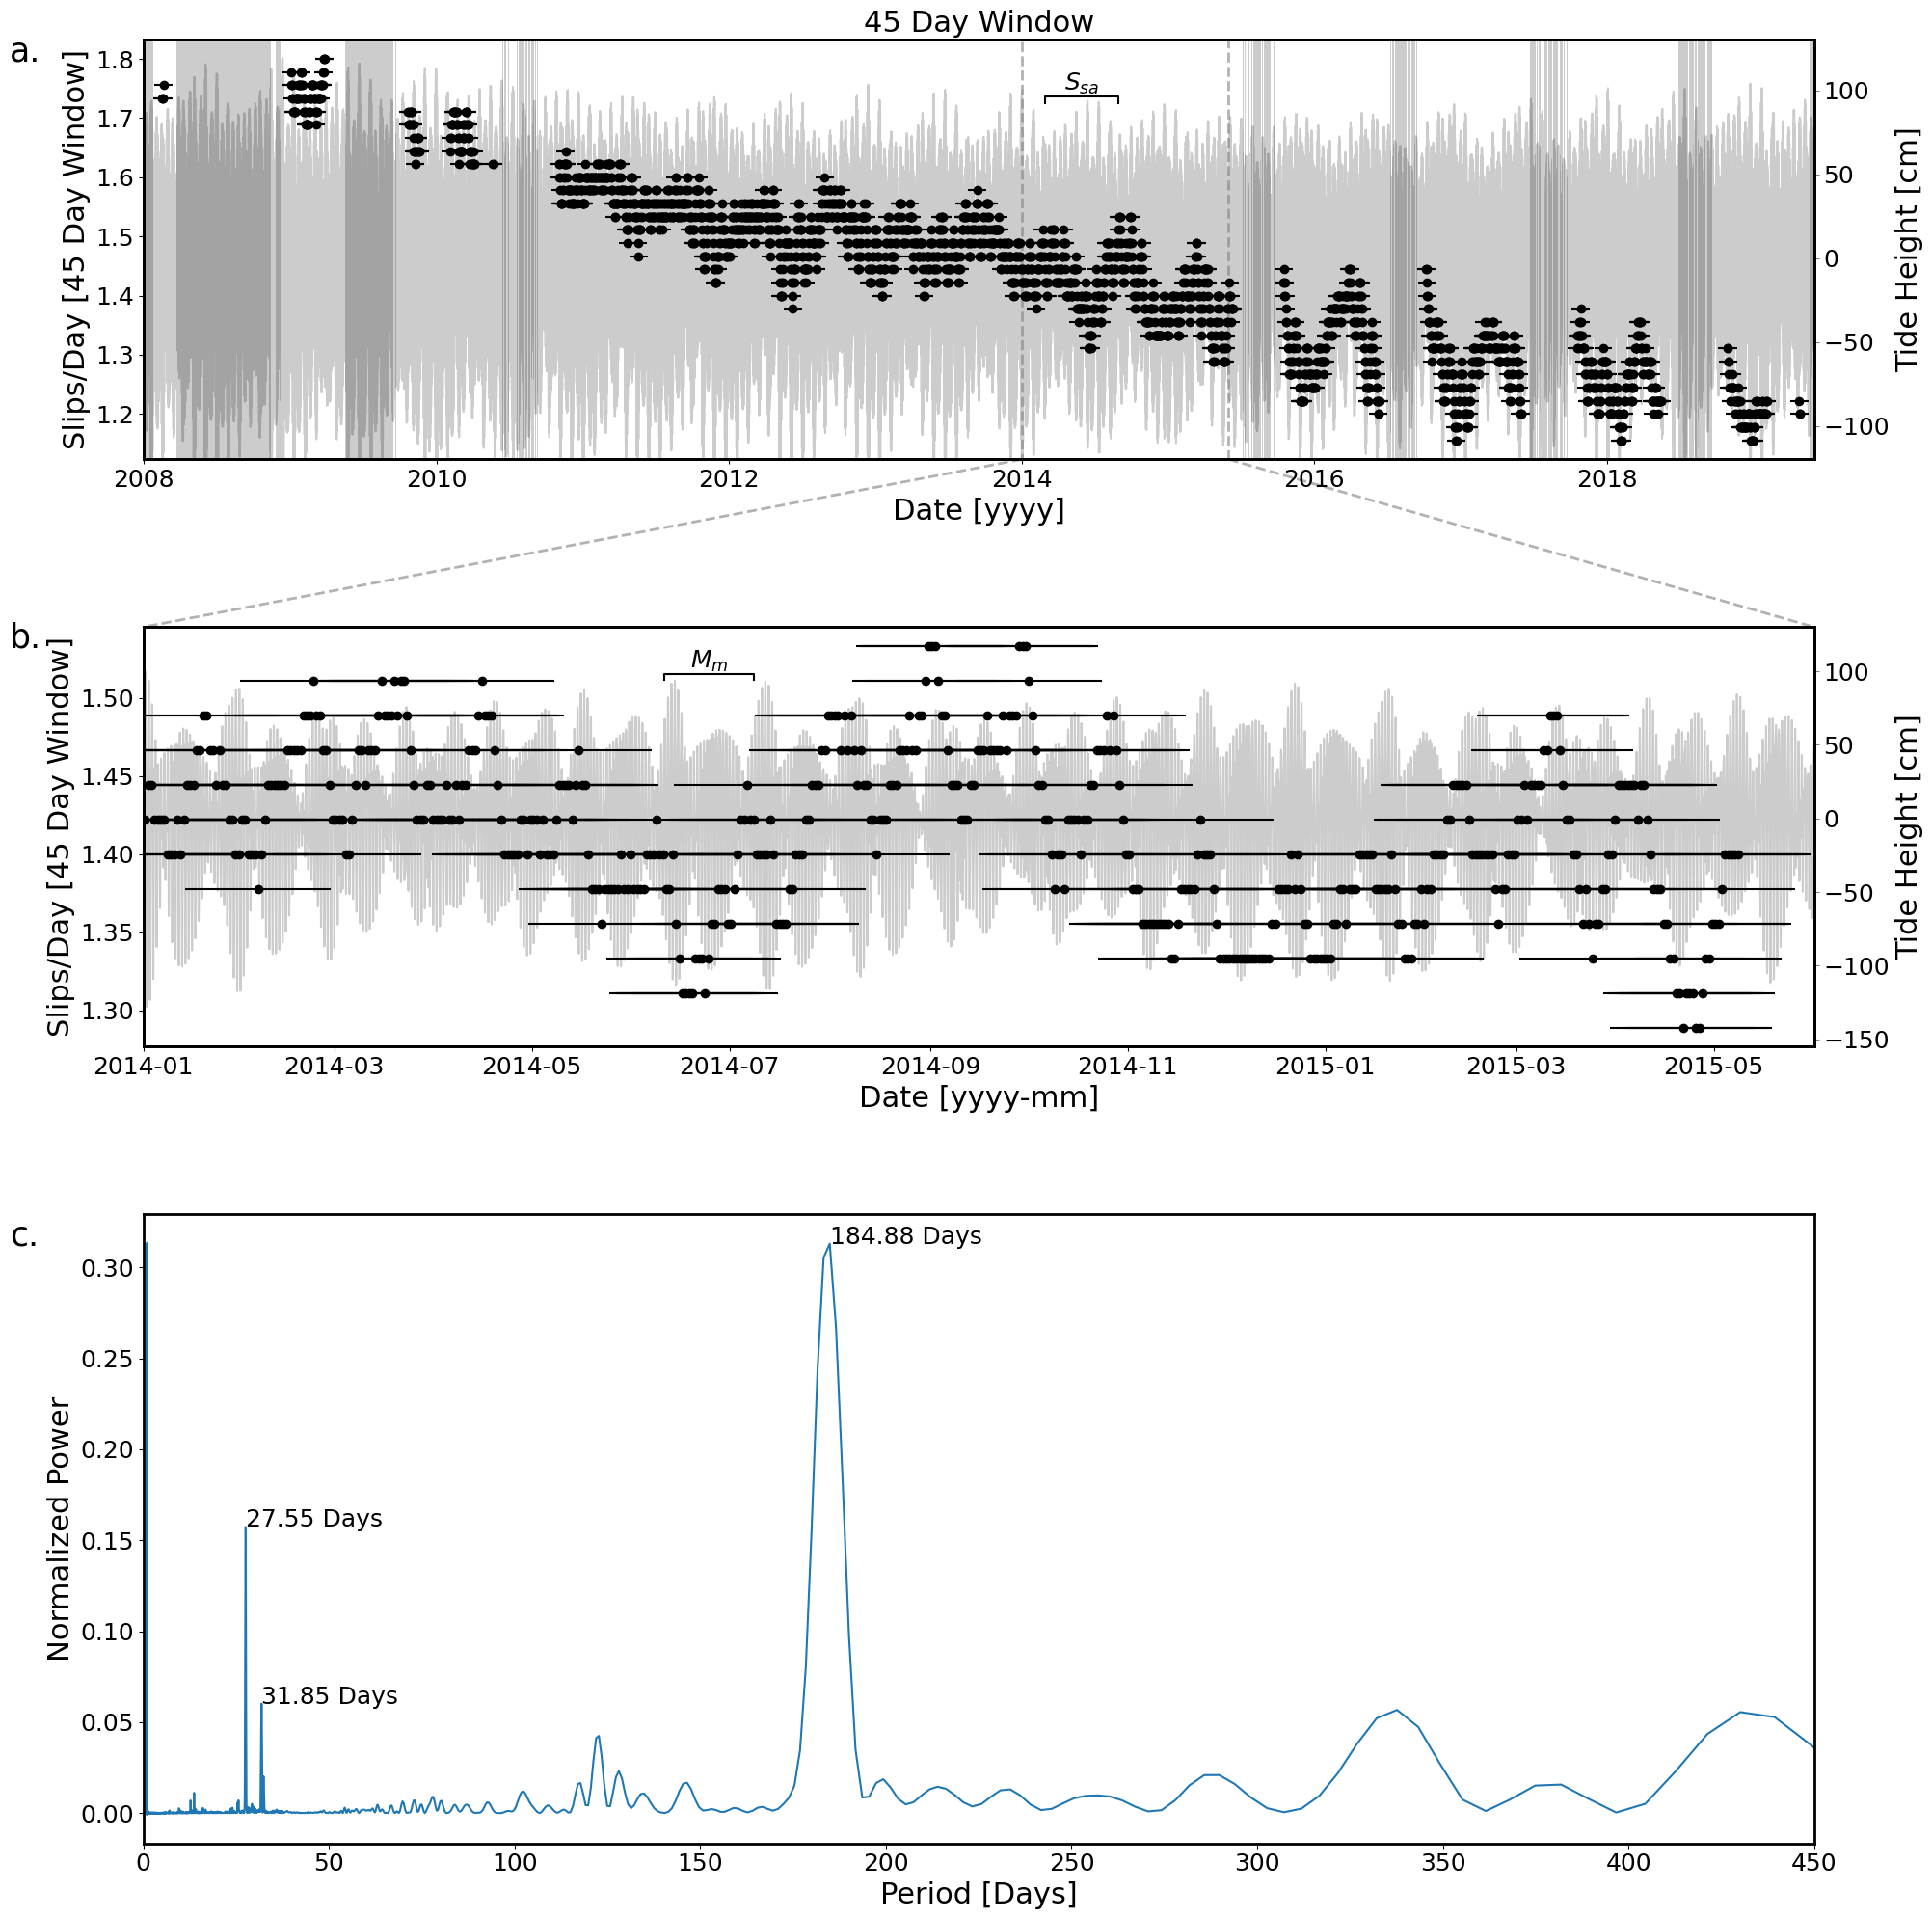

In [28]:
# Plot FIGS 4, S4, S5

SEC_TO_DAY = 3600 * 24
SEC_TO_HR = 3600
xlim = 450

viridis = mpl.colormaps["viridis"].resampled(20)
# Add window to rolling avg dict
for i, window in enumerate([3, 27, 45]):
    rolling_avg_dicts[i]["window"] = window


for rolling_avg_dict in rolling_avg_dicts:
    fig, (ax1, ax2, ax3) = plt.subplots(
        3,
        1,
        figsize=[20, 20],
        gridspec_kw={"height_ratios": [1, 1, 1.5]},
        layout="constrained",
    )
    skip_starts = rolling_avg_dict["skip_starts"]
    skip_ends = rolling_avg_dict["skip_ends"]
    skip_middles = rolling_avg_dict["skip_middles"]
    skips = rolling_avg_dict["skips"]
    tot_slips = rolling_avg_dict["tot_slips"]
    spacings = rolling_avg_dict["spacings"]
    window = rolling_avg_dict["window"]
    plot_rolling_avg_section(
        ax1,
        ax2,
        window,
        slide,
        skip_starts,
        skip_ends,
        skip_middles,
        skips,
        tot_slips,
        spacings,
    )

    # Lomb Scargle
    dates_as_sec = [a.timestamp() for a in skip_middles]
    tot_slips_masked = np.ma.masked_array(
        tot_slips, mask=np.invert(~np.isnan(tot_slips))
    )
    dates_as_sec_masked = np.ma.masked_array(
        dates_as_sec, mask=np.invert(~np.isnan(tot_slips))
    )
    tot_slips_masked = np.ma.compressed(tot_slips_masked)
    dates_as_sec_masked = np.ma.compressed(dates_as_sec_masked)
    tot_slips_detrended = scipy.signal.detrend(tot_slips_masked)

    # Spectrogram of rolling avg slips using lomb scargle
    frequency, power = LombScargle(dates_as_sec_masked, tot_slips_detrended).autopower()

    pks = scipy.signal.find_peaks(power[:10000], height=0.06)[0]
    # ax.plot(frequency[pks], power[pks], 'ro')
    period = 1 / frequency / SEC_TO_DAY  # Days
    ax3.plot(period, power)
    ax3.set_xlabel("Period [Days]", fontsize=22)
    ax3.set_ylabel("Normalized Power", fontsize=22)
    ax3.xaxis.set_tick_params(labelsize=18)
    ax3.yaxis.set_tick_params(labelsize=18)
    ax3.set_xlim(0, xlim)
    # ax.set_ylim(0,0.1)

    for pk, pwr in zip(period[pks], power[pks]):
        if pk < xlim:
            if pk > 0:
                print(f"{pk} Days, Power = {pwr}")
                ax3.text(pk + 0.001e-5, pwr, f"{pk:.2f} Days", fontsize=18)
            else:
                print(f"{pk} Hours, Power = {pwr}")
                ax3.text(pk + 0.001e-5, pwr, f"{pk:.2f} Hours", fontsize=18)

    ax1.annotate("a.", (-0.08, 0.95), xycoords="axes fraction", fontsize=25)
    ax2.annotate("b.", (-0.08, 0.95), xycoords="axes fraction", fontsize=25)
    ax3.annotate("c.", (-0.08, 0.95), xycoords="axes fraction", fontsize=25)

    st3 = datetime.datetime(2014, 1, 1)
    ed3 = datetime.datetime(2015, 6, 1)

    # Adds patch and zoom effect
    rect = plt.Rectangle(
        (st3, -200),
        ed3 - st3,
        1000,
        facecolor="none",
        zorder=0,
        alpha=0.3,
        edgecolor="black",
        linewidth=2,
        linestyle="--",
    )
    ax1.add_patch(rect)
    zoom_effect01(
        ax1,
        ax2,
        mdates.date2num(st3),
        mdates.date2num(ed3),
        ec="black",
        lw=2,
        alpha=0.3,
        ls="--",
    )
    fig.tight_layout()
    fig.savefig(f"Rolling_Avg_{window}_Day_Window.png")

In [43]:
# Plotting function
def plot_rolling_avg_agu(
    ax1,
    window,
    slide_len,
    skip_starts,
    skip_ends,
    skip_middles,
    skips,
    tot_slips,
    spacings,
):
    # Skipped slips by number of slips in xx period
    ax2 = ax1.twinx()
    (
        ax1.plot(
            dates_timeseries, ev_data["tidesgz05"], zorder=1, color="gray", alpha=0.4
        ),
    )
    for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
        start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        rect = plt.Rectangle(
            (start, -200), interval, 1000, facecolor="#D34B29", alpha=0.1, zorder=3
        )
        ax1.add_patch(rect)

    ax1.set_xlim(datetime.datetime(2008, 1, 1), datetime.datetime(2019, 6, 1))
    ax1.set_ylim(-120, 130)

    xerr = [(end - start) // 2 for start, end in zip(skip_starts, skip_ends)]
    norm_slips = [i / window for i in tot_slips]
    ax2.errorbar(
        skip_middles,
        norm_slips,
        xerr=xerr,
        fmt=".",
        color="#21314D",
        zorder=2,
        markersize=20,
    )
    # ax2.plot(skip_middles, tot_slips, color='blue')

    timestamps = [a.timestamp() for a in skip_middles]

    compressed_tot_slips = np.ma.masked_invalid(tot_slips)
    compressed_timestamps = np.ma.masked_where(
        np.ma.getmask(compressed_tot_slips), timestamps
    )
    compressed_tot_slips = np.ma.compressed(compressed_tot_slips)
    compressed_timestamps = np.ma.compressed(compressed_timestamps)

    coef = np.polyfit(compressed_timestamps, compressed_tot_slips, 1)
    lst_sqrs_fit = np.poly1d(coef)

    datetimes = [datetime.datetime.fromtimestamp(a) for a in compressed_timestamps]
    # ax2.plot(datetimes, lst_sqrs_fit(compressed_timestamps),color='blue',zorder=3)

    # Just a line so manually extract slope
    delta_y = (
        lst_sqrs_fit(compressed_timestamps)[-1] - lst_sqrs_fit(compressed_timestamps)[0]
    )
    delta_x = datetimes[-1] - datetimes[0]

    print(delta_y, delta_x)
    slope = delta_y / delta_x.total_seconds() * 3600 * 24 * 365
    print(slope)  # Slips / year
    ax1.yaxis.set_label_position("right")
    ax1.yaxis.tick_right()
    ax2.yaxis.set_label_position("left")
    ax2.yaxis.tick_left()
    ax1.set_xlabel("Date [yyyy]", size=55)
    ax1.set_ylabel("Tide Height [cm]", size=55)
    ax2.set_ylabel(f"Slips/Day [{window} Day Window]", size=40, color="black")
    ax1.xaxis.set_tick_params(labelsize=42)
    ax1.yaxis.set_tick_params(labelsize=42, color="gray")
    ax2.yaxis.set_tick_params(labelsize=42, colors="black")
    # ax2.spines['left'].set_color('red')

    ssa_time = datetime.timedelta(days=182.63)
    ssa_start = datetime.datetime(2014, 3, 1)
    annotationagu(ax1, ssa_start, ssa_start + ssa_time, 92, 96, "$S_{sa}$")

    mm_time = datetime.timedelta(days=27.55)
    mm_start = datetime.datetime(2013, 6, 11)
    annotationagu(ax1, mm_start, mm_start + mm_time, 94, 98, "$M_{m}$")

In [30]:
def annotationagu(ax, x1, x2, y1, y2, text):
    """Draws an annotated bracket."""
    xs = [x1, x1, x2, x2]
    ys = [y1, y2, y2, y1]
    ax.plot(xs, ys, "k-", linewidth=3)
    ax.text((x2 - x1) / 2 + x1, y2 + 0.1, text, ha="center", va="bottom", fontsize=45)

-25.044711550882766 4086 days, 0:00:00
-2.2372294948781715


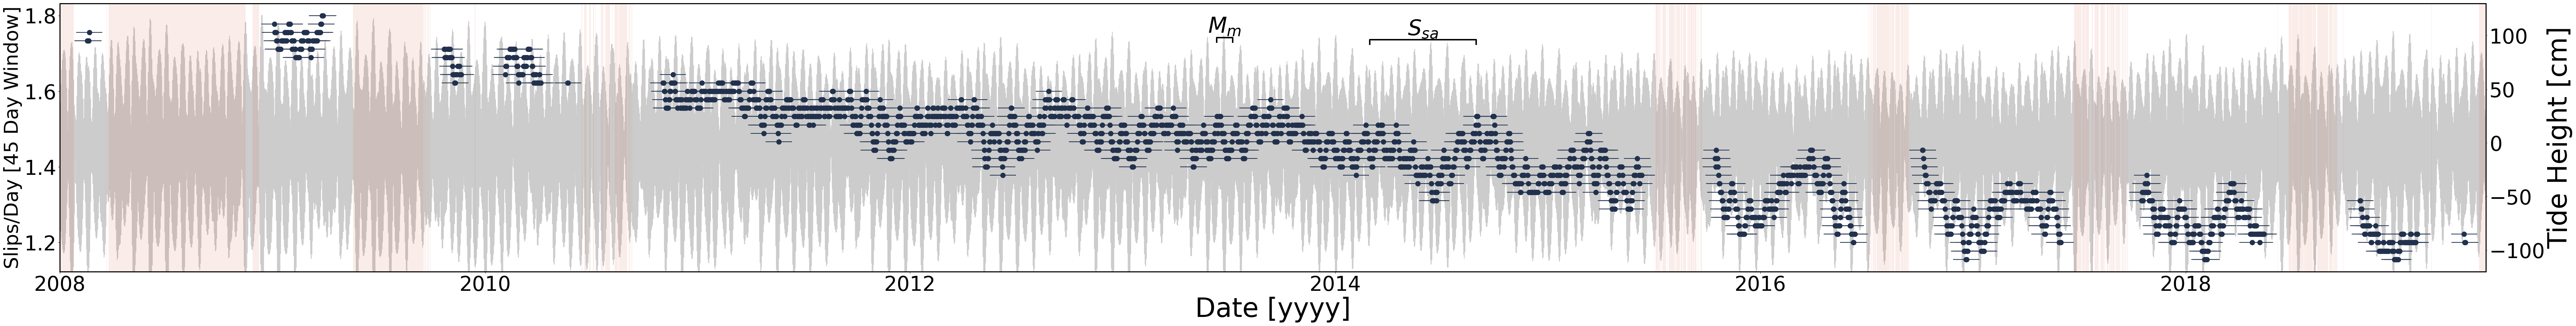

In [44]:
# Rolling avg plot for AGU24 and GRADS
fig, ax1 = plt.subplots(
    1,
    1,
    figsize=[90, 10],
)
plot_rolling_avg_agu(
    ax1,
    window,
    slide,
    skip_starts,
    skip_ends,
    skip_middles,
    skips,
    tot_slips,
    spacings,
)

In [ ]:
# TEST OF STRAIN RATe
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters
E = 1.0  # Elastic modulus (arbitrary units)
eta = 1.0  # Viscosity (arbitrary units)
strain_rate = 1.0  # Constant strain rate (arbitrary units)
k = E / eta  # Parameter for nonlinear term
sigma0 = 0.0  # Initial stress


# Differential equation: dsigma/dt = E * strain_rate - (E/eta) * sigma^3
def maxwell_model(t, sigma):
    C = E * strain_rate  # Constant term from strain rate
    return C - k * sigma**3


# Time range for the integration
t_span = (0, 10)  # From t=0 to t=10
t_eval = np.linspace(t_span[0], t_span[1], 500)  # Points to evaluate

# Initial condition
y0 = [sigma0]

# Solve the differential equation
solution = solve_ivp(maxwell_model, t_span, y0, t_eval=t_eval, method="RK45")

# Extract results
t = solution.t
sigma = solution.y[0]

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(t, sigma, label="Stress $\sigma(t)$")
plt.axhline(
    (eta * strain_rate / E) ** (1 / 3),
    color="r",
    linestyle="--",
    label="Steady-state $\sigma_s$",
)
plt.title("Stress Evolution in Maxwell Material")
plt.xlabel("Time $t$")
plt.ylabel("Stress $\sigma(t)$")
plt.legend()
plt.grid()
plt.show()

In [32]:
def load(file):
    """
    Load processed gps data file into pandas table.
    Columns
        longitude, latitude, elevation, time, day_of_year
        x, y, dist

    data_table = load(file)
    """
    data = pd.DataFrame()  # Create Pandas DataFrame
    flip = False
    # Read data file

    # Convert longitude and latitude from deg min sec to fractional degrees
    # Three different file formats so try one first and try the other if it
    # throws a not found exception.
    try:
        # CSRS-PPP 2024
        d = pd.read_csv(
            file, skiprows=3, sep="\\s+"
        )  # delim_whitespace=True depreciated, used \\s+ instead
        # Only take 15 or 30 sec intervals if data is finer spaced
        d = d.loc[
            d["HR:MN:SS.SS"].str.endswith("00.00")
            | d["HR:MN:SS.SS"].str.endswith("15.00")
            | d["HR:MN:SS.SS"].str.endswith("30.00")
            | d["HR:MN:SS.SS"].str.endswith("45.00")
            | d["HR:MN:SS.SS"].str.endswith("16.00")  # Slw1 only, move to 15 sec
            | d["HR:MN:SS.SS"].str.endswith("46.00")  # Slw1 only, move to 45 sec
        ]
        data["longitude"] = d["LONDD"] - d["LONMN"] / 60 - d["LONSS"] / 60 / 60
        data["latitude"] = d["LATDD"] - d["LATMN"] / 60 - d["LATSS"] / 60 / 60
        data["time"] = pd.to_datetime(d["YEAR-MM-DD"] + "T" + d["HR:MN:SS.SS"])
        data.loc[data["time"].dt.second == 46, "time"] = data["time"] - pd.Timedelta(
            seconds=1
        )  # Slw1 only, move to 45 sec
        data.loc[data["time"].dt.second == 16, "time"] = data["time"] - pd.Timedelta(
            seconds=1
        )  # Slw1 only, move to 15 sec
        data["day_of_year"] = d["DAYofYEAR"]

    # If not in 2024 format, may be in an older format, tested for below...
    except Exception:
        try:
            d = pd.read_csv(file, skiprows=7, sep="\\s+")
            data["longitude"] = d["LON(d)"] - d["LON(m)"] / 60 - d["LON(s)"] / 60 / 60
            data["latitude"] = d["LAT(d)"] - d["LAT(m)"] / 60 - d["LAT(s)"] / 60 / 60
            data["time"] = pd.to_datetime(d["YEAR-MM-DD"] + "T" + d["HR:MN:SS.SSS"])
            data["day_of_year"] = d["DOY"]
        except Exception:
            d = pd.read_csv(file, skiprows=3, sep="\\s+")
            data["longitude"] = d["LONDD"] - d["LONMN"] / 60 - d["LONSS"] / 60 / 60
            data["latitude"] = d["LATDD"] - d["LATMN"] / 60 - d["LATSS"] / 60 / 60
            data["time"] = data["time"] = pd.to_datetime(
                d["YEAR-MM-DD"] + "T" + d["HR:MN:SS.SSS"]
            )
            data["day_of_year"] = d["DAYofYEAR"]

    data["elevation"] = d["HGT(m)"]
    data["sats"] = d["NSV"]
    data["GDOP"] = d["GDOP"]

    # Check length before
    # Convert to Antarctic Polar Stereographic
    x, y = ll2xy(lon=data["longitude"], lat=data["latitude"])
    data["x"] = x
    data["y"] = y

    # Look at data and decide if to flip
    if len(data.index) > 1:
        diff = data["time"].iloc[0] - data["time"].iloc[1]
        if diff > datetime.timedelta(seconds=0):
            flip = True

        # Keep in if statement because fails if no data
        x0 = data["x"].iloc[0]
        y0 = data["y"].iloc[0]

        data["dist"] = np.sqrt((data["x"] - x0) ** 2 + (data["y"] - y0) ** 2)
    return data, flip

In [33]:
# Load gz05, gz20 data [~3.5 min]
# Create Catalog
sys.path.insert(
    0,
    "/mnt/c/Users/ZacharyKatz/Desktop/WhillansCatPaper/WhillansCatalogPaper/src/Catalog",
)
import os

import scipy.signal
from astropy.timeseries import LombScargle
import datetime

gz05dir2011 = (
    "/mnt/c/users/ZacharyKatz/Desktop/Mines/FA23/GPGN598A/Term Paper/S1/gz05-2011"
)
gz05dir2013 = (
    "/mnt/c/users/ZacharyKatz/Desktop/Mines/FA23/GPGN598A/Term Paper/S1/gz05-2013"
)
gz20dir2017 = (
    "/mnt/c/users/ZacharyKatz/Desktop/Mines/FA23/GPGN598A/Term Paper/S1/gz20-2017"
)
gz20dir2018 = (
    "/mnt/c/users/ZacharyKatz/Desktop/Mines/FA23/GPGN598A/Term Paper/S1/gz20-2018"
)

# gz05 Data
# Load time series into Dataframe
gz052011data = pd.DataFrame()
gz052013data = pd.DataFrame()
gz202017data = pd.DataFrame()
gz202018data = pd.DataFrame()

dirs = [gz05dir2011, gz05dir2013, gz20dir2017, gz20dir2018]
datas = [gz052011data, gz052013data, gz202017data, gz202018data]

i = 0

gz_secs = []
gz_xs = []
xfs = []
tfs = []
data_all = []

for dir, data in zip(dirs, datas):
    i = 0
    for gps in os.listdir(dir):
        if gps.endswith(".pos"):
            i = i + 1
            ind_data, flip = load(dir + "/" + gps)
            if flip:
                ind_data = ind_data.reindex(index=ind_data.index[::-1])
            if i == 1 or ind_data["time"].iloc[0] - data["time"].iloc[
                -1
            ] == datetime.timedelta(seconds=15):
                data = pd.concat([data, ind_data])
            else:
                print(gps)
                break

    data_all.append(data)

    # Extract times as datetime objects
    times = [
        datetime.datetime(
            time.year, time.month, time.day, time.hour, time.minute, time.second
        )
        for time in data["time"]
    ]

    # Calcluate date since Jan 1, 1992 [For Comparison with PyTMD]
    time_since_date = [
        (time - datetime.datetime(2011, 1, 12, 0, 0, 0)) for time in times
    ]
    in_hours = [time.total_seconds() / 3600 for time in time_since_date]
    in_secs = [time.total_seconds() for time in time_since_date]

    # Make Spectrum
    N = len(in_secs)
    T = 15.0  # Time between samples
    t = np.linspace(0.0, N * T, N, endpoint=False)
    detrended_x = scipy.signal.detrend(data["elevation"])
    hann = scipy.signal.windows.hann(N)
    hanned_x = detrended_x * hann  # Hann filter before Fourier Transform

    xf = scipy.fft.fft(detrended_x)
    tf = scipy.fft.fftfreq(N, T)[: N // 2]

    gz_secs.append(in_secs)
    gz_xs.append(detrended_x)
    xfs.append(xf)
    tfs.append(tf)

gz053500.pos
gz051690.pos
gz202480.pos
gz201590.pos


In [34]:
# Calculate distance between gz05 and gz20
dist = np.sqrt(
    (data_all[2]["x"].iloc[0] - data_all[0]["x"].iloc[0]) ** 2
    + (data_all[2]["y"].iloc[0] - data_all[0]["y"].iloc[0]) ** 2
)
print(dist)

906.1317245862715


In [ ]:
for data in data_all:
    print(len(data))

/tmp/ipykernel_103736/3095438877.py:8: RuntimeWarning: divide by zero encountered in divide
  period = 1 / tf / SEC_TO_HR  # Day


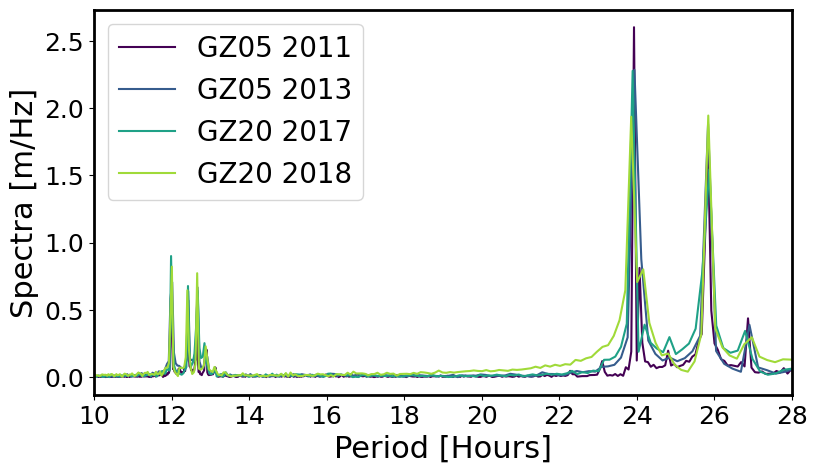

In [35]:
SEC_TO_HR = 3600
fig, ax = plt.subplots(figsize=(9, 5))
labels = ["GZ05 2011", "GZ05 2013", "GZ20 2017", "GZ20 2018"]
colors = ["#440154", "#365c8d", "#1fa187", "#a0da39"]
for i, (xf, tf, gz_sec, gz_x) in enumerate(zip(xfs, tfs, gz_secs, gz_xs)):
    N = len(gz_sec)
    # PLot Spectrogram
    period = 1 / tf / SEC_TO_HR  # Day
    ax.plot(period, 12.0 / N * np.abs(xf[0 : N // 2]), label=labels[i], color=colors[i])
ax.set_xlim(10, 28)
ax.set_xlabel("Period [Hours]", fontsize=22)
ax.set_ylabel("Spectra [m/Hz]", fontsize=22)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
ax.legend(fontsize=20)

In [36]:
# Find peaks for form factor analysis
constitutents = {"K1": [], "O1": [], "M2": [], "S2": []}
for i, (xf, tf, gz_sec, gz_x) in enumerate(zip(xfs, tfs, gz_secs, gz_xs)):
    N = len(gz_sec)
    # PLot Spectrogram
    period = 1 / tf / SEC_TO_HR  # Day
    spectra = 12.0 / N * np.abs(xf[0 : N // 2])
    peaks = scipy.signal.find_peaks(spectra, height=0.5, distance=1)
    for index, val in zip(peaks[0], peaks[1]["peak_heights"]):
        print(f"Period: {period[index]:.2f} Hours, Spectra: {val:.2f} m/Hz")
        if period[index] > 23.8 and period[index] < 24:
            constitutents["K1"].append(val)
        elif period[index] > 25.8 and period[index] < 26:
            constitutents["O1"].append(val)
        elif period[index] > 11.9 and period[index] < 12.1:
            constitutents["M2"].append(val)
        elif period[index] > 12.3 and period[index] < 12.5:
            constitutents["S2"].append(val)

print(constitutents)

Period: 25.85 Hours, Spectra: 1.71 m/Hz
Period: 24.08 Hours, Spectra: 0.81 m/Hz
Period: 23.93 Hours, Spectra: 2.60 m/Hz
Period: 12.66 Hours, Spectra: 0.63 m/Hz
Period: 12.43 Hours, Spectra: 0.57 m/Hz
Period: 12.00 Hours, Spectra: 0.71 m/Hz
Period: 25.85 Hours, Spectra: 1.88 m/Hz
Period: 23.95 Hours, Spectra: 2.28 m/Hz
Period: 12.67 Hours, Spectra: 0.67 m/Hz
Period: 12.43 Hours, Spectra: 0.64 m/Hz
Period: 12.02 Hours, Spectra: 0.71 m/Hz
Period: 25.88 Hours, Spectra: 1.54 m/Hz
Period: 23.90 Hours, Spectra: 2.28 m/Hz
Period: 12.68 Hours, Spectra: 0.64 m/Hz
Period: 12.42 Hours, Spectra: 0.68 m/Hz
Period: 11.99 Hours, Spectra: 0.90 m/Hz
Period: 25.85 Hours, Spectra: 1.94 m/Hz
Period: 24.17 Hours, Spectra: 0.80 m/Hz
Period: 23.86 Hours, Spectra: 1.94 m/Hz
Period: 12.66 Hours, Spectra: 0.77 m/Hz
Period: 12.41 Hours, Spectra: 0.65 m/Hz
Period: 12.01 Hours, Spectra: 0.82 m/Hz
{'K1': [2.601395499444048, 2.2847925026001117, 2.2769270752665753, 1.9361217926984313], 'O1': [1.7120595641583187, 1.882

/tmp/ipykernel_103736/2690468298.py:6: RuntimeWarning: divide by zero encountered in divide
  period = 1 / tf / SEC_TO_HR  # Day


In [37]:
f_value = [
    (constitutents["K1"][i] + constitutents["O1"][i])
    / (constitutents["M2"][i] + constitutents["S2"][i])
    for i in range(len(constitutents["K1"]))
]
print(f_value)

[3.3629104151533324, 3.094426120845267, 2.420917219314271, 2.644290369375634]


/tmp/ipykernel_103736/3426358444.py:13: RuntimeWarning: divide by zero encountered in divide
  period = 1 / tf / SEC_TO_HR  # Day


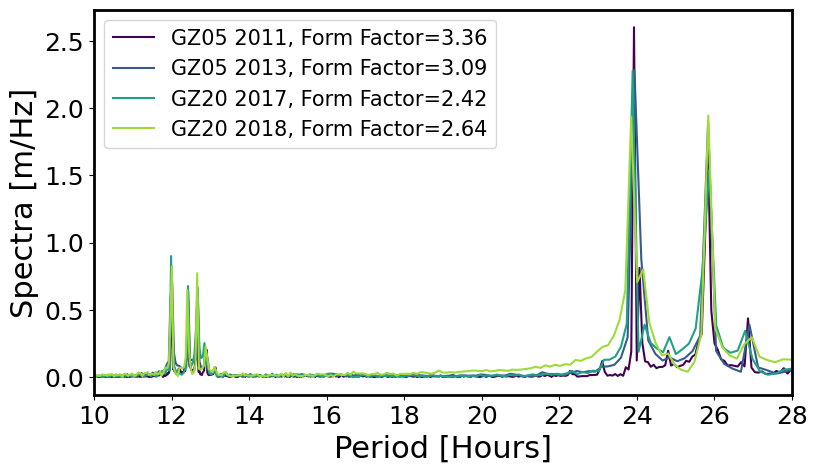

In [38]:
SEC_TO_HR = 3600
fig, ax = plt.subplots(figsize=(9, 5))
labels = [
    f"GZ05 2011, Form Factor={f_value[0]:.2f}",
    f"GZ05 2013, Form Factor={f_value[1]:.2f}",
    f"GZ20 2017, Form Factor={f_value[2]:.2f}",
    f"GZ20 2018, Form Factor={f_value[3]:.2f}",
]
colors = ["#440154", "#365c8d", "#1fa187", "#a0da39"]
for i, (xf, tf, gz_sec, gz_x) in enumerate(zip(xfs, tfs, gz_secs, gz_xs)):
    N = len(gz_sec)
    # PLot Spectrogram
    period = 1 / tf / SEC_TO_HR  # Day
    ax.plot(period, 12.0 / N * np.abs(xf[0 : N // 2]), label=labels[i], color=colors[i])
ax.set_xlim(10, 28)
ax.set_xlabel("Period [Hours]", fontsize=22)
ax.set_ylabel("Spectra [m/Hz]", fontsize=22)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
ax.legend(fontsize=15)

In [39]:
# Plot all gzs and pick out peaks to compute change in tidal form factor
SEC_TO_HR = 3600
periods = []
powers = []
for i, (in_secs, detrended_x) in enumerate(zip(gz_secs, gz_xs)):
    frequency, power = LombScargle(in_secs, detrended_x).autopower()
    period = 1 / frequency / SEC_TO_HR  # Day
    periods.append(period)
    powers.append(power)

IndexError: list index out of range

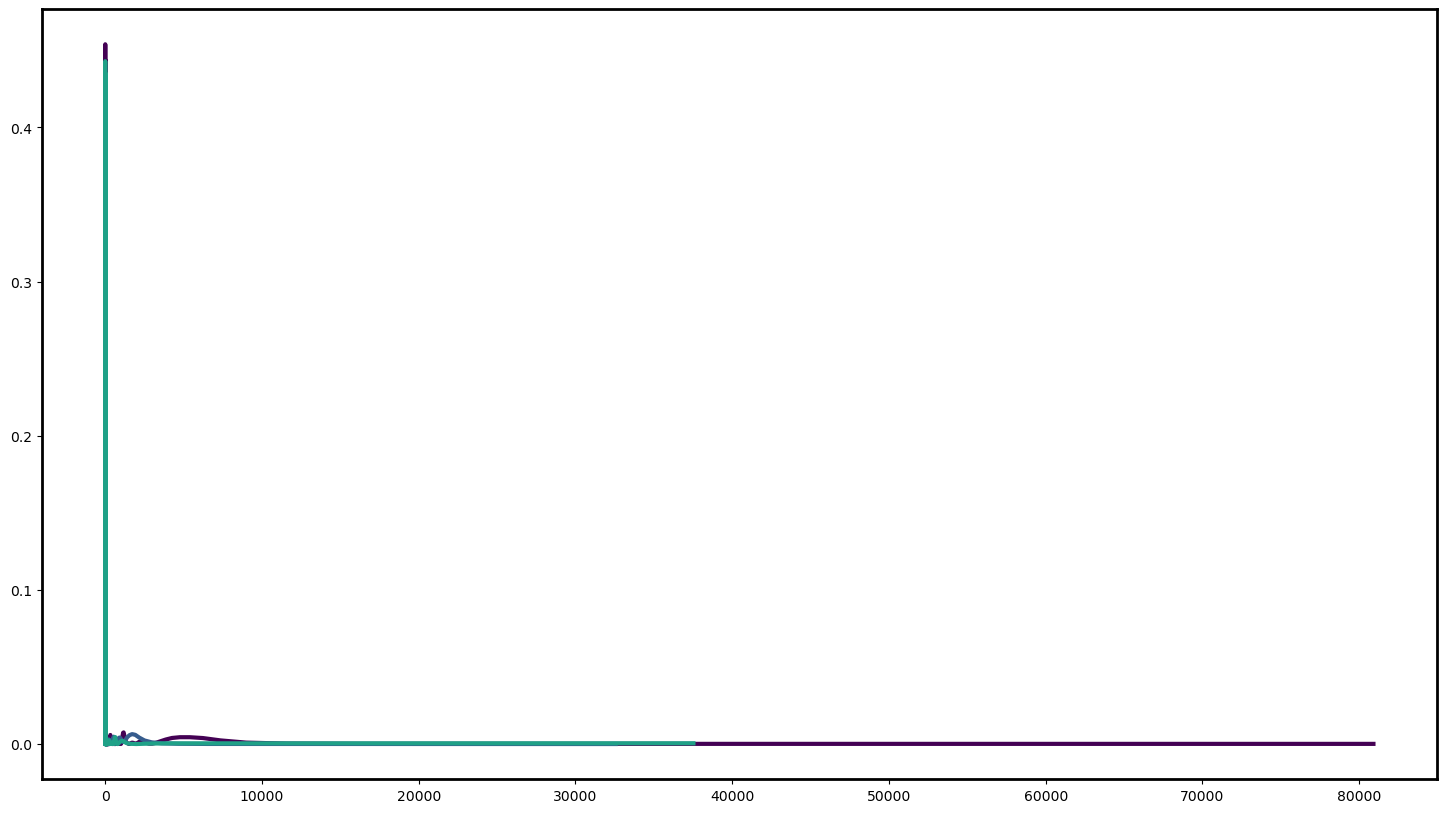

In [40]:
fig, ax = plt.subplots(
    1,
    1,
    figsize=[18, 10],
)
labels = ["GZ05 2013", "GZ20 2017", "GZ02 2018"]
colors = ["#440154", "#365c8d", "#1fa187", "#a0da39"]
for i, (period, power) in enumerate(zip(periods, powers)):
    ax.plot(period, power, color=colors[i], linewidth=3, label=labels[i])

ax.set_xlabel("Period [Hours]", fontsize=22)
ax.set_ylabel("Normalized Power", fontsize=22)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
ax.set_xlim(22, 28)
ax.legend(fontsize=22)

'\nfor pk, pwr in zip(period[pks], power[pks]):\n    if pk < xlim:\n        if pk > 0:\n            print(f"{pk} Days, Power = {pwr}")\n            ax3.text(pk + 0.001e-5, pwr, f"{pk:.2f} Days", fontsize=18)\n        else:\n            print(f"{pk} Hours, Power = {pwr}")\n            ax3.text(pk + 0.001e-5, pwr, f"{pk:.2f} Hours", fontsize=18)\n\n\n\n# PLot Spectrogram\nHR_TO_S = 3600\nperiod = 1/tf / SEC_TO_DAY # Convert to hrs\nax2.plot(period, 12.0/N * np.abs(xf[0:N//2]),\'k\')\nax2.set_xlabel("Period [Hours]",fontsize=14)\nax2.set_ylabel("Spectrum [m/Hz]",fontsize=14)\n#ax2.set_xlim(10,28)\nax2.tick_params(labelsize=14)\n'

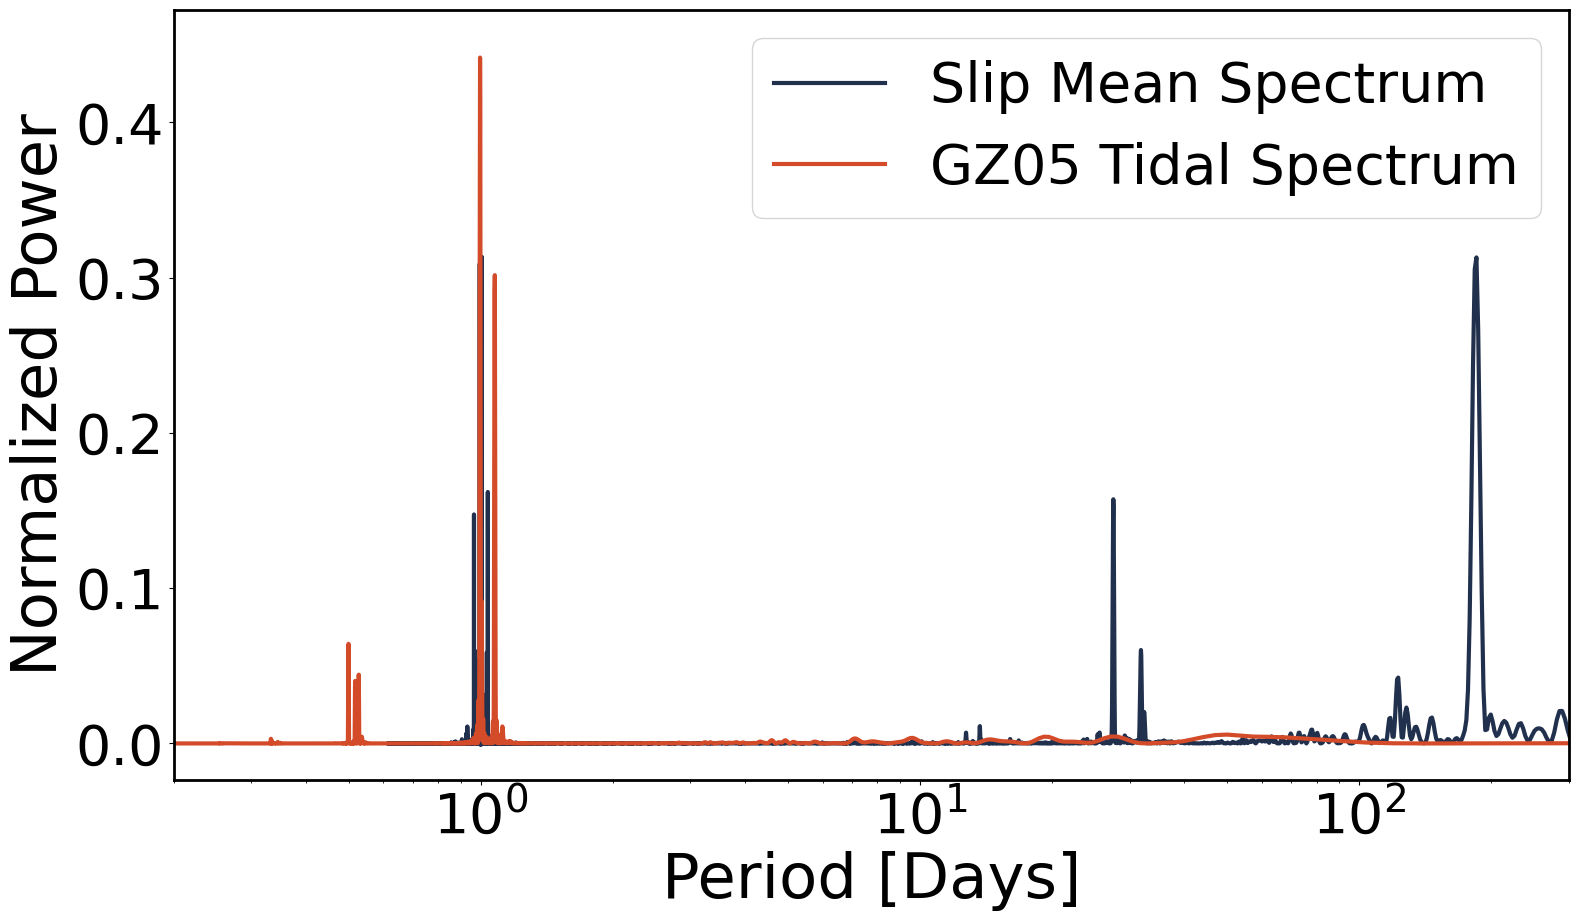

In [42]:
# Plot tide and rolling sum spectra as one plot
# Lomb Scargle
fig, ax3 = plt.subplots(
    1,
    1,
    figsize=[18, 10],
)
dates_as_sec = [a.timestamp() for a in skip_middles]
tot_slips_masked = np.ma.masked_array(tot_slips, mask=np.invert(~np.isnan(tot_slips)))
dates_as_sec_masked = np.ma.masked_array(
    dates_as_sec, mask=np.invert(~np.isnan(tot_slips))
)
tot_slips_masked = np.ma.compressed(tot_slips_masked)
dates_as_sec_masked = np.ma.compressed(dates_as_sec_masked)
tot_slips_detrended = scipy.signal.detrend(tot_slips_masked)

# Spectrogram of rolling avg slips using lomb scargle
frequency, power = LombScargle(dates_as_sec_masked, tot_slips_detrended).autopower()

pks = scipy.signal.find_peaks(power[:10000], height=0.06)[0]
# ax.plot(frequency[pks], power[pks], 'ro')
period = 1 / frequency / SEC_TO_DAY  # Days
ax3.plot(period, power, linewidth=3, label="Slip Mean Spectrum", color="#21314D")
ax3.set_xlabel("Period [Days]", fontsize=45)
ax3.set_ylabel("Normalized Power", fontsize=45)
ax3.xaxis.set_tick_params(labelsize=40)
ax3.yaxis.set_tick_params(labelsize=40)


xlim = 300
ax3.set_xlim(0.2, xlim)
# Set log
ax3.set_xscale("log")
# ax.set_ylim(0,0.1)

frequency, power = LombScargle(in_secs, detrended_x).autopower()
period = 1 / frequency / SEC_TO_DAY  # Day
ax3.plot(period, power, color="#D34B29", linewidth=3, label="GZ05 Tidal Spectrum")
ax3.legend(fontsize=40)

"""
for pk, pwr in zip(period[pks], power[pks]):
    if pk < xlim:
        if pk > 0:
            print(f"{pk} Days, Power = {pwr}")
            ax3.text(pk + 0.001e-5, pwr, f"{pk:.2f} Days", fontsize=18)
        else:
            print(f"{pk} Hours, Power = {pwr}")
            ax3.text(pk + 0.001e-5, pwr, f"{pk:.2f} Hours", fontsize=18)



# PLot Spectrogram
HR_TO_S = 3600
period = 1/tf / SEC_TO_DAY # Convert to hrs
ax2.plot(period, 12.0/N * np.abs(xf[0:N//2]),'k')
ax2.set_xlabel("Period [Hours]",fontsize=14)
ax2.set_ylabel("Spectrum [m/Hz]",fontsize=14)
#ax2.set_xlim(10,28)
ax2.tick_params(labelsize=14)
"""